# So sánh Binomial và Approximation

In [1]:
! pip install -q deap pulp pandas scipy highspy "cvxpy[CBC,CVXOPT,GLOP,GLPK,GUROBI,MOSEK,PDLP,SCIP,XPRESS,HiGHS]"

In [2]:
import cvxpy as cp
print("CVXPY version:", cp.__version__)
print("Installed solvers:", cp.installed_solvers())

CVXPY version: 1.6.4
Installed solvers: ['CBC', 'CLARABEL', 'CVXOPT', 'GLOP', 'GLPK', 'GLPK_MI', 'GUROBI', 'HIGHS', 'MOSEK', 'OSQP', 'PDLP', 'SCIP', 'SCIPY', 'SCS', 'XPRESS']


# Mục mới

In [3]:
import math
import numpy as np
from scipy.stats import binom

# --- Example Calculation ---
S = 211  # Số ghế có sẵn
n = 248  # Số vé đã bán
p = 0.9  # Xác suất hành khách đến

# Assume an average compensation rate for this class (e.g., calculated from fare-level compensation amounts)
avg_comp = 6000000  # 6,000,000 VND (for example)

# --- Function to Compute Expected Number of Bumped Passengers ---
def expected_bumped_tickets(n, S, p):
    """Tính số hành khách bị từ chối theo công thức trong hình"""
    E_i = sum(1 - binom.cdf(j - 1, n, p) for j in range(S + 1, n + 1))
    return E_i

binomial_cdf = expected_bumped_tickets(n, S, p)
comp_cost = binomial_cdf*avg_comp

print("\nBinomial CDF:")
print("  Expected bumped tickets:", expected_bumped_tickets(n, S, p))
print("  Total compensation cost: {:,.0f} VND".format(comp_cost))


# --- Alternative: Linear Approximation for Comparison ---
def expected_bumped_linear(n, S, p):
    return max(p * n - S, 0)

linear_bumped = expected_bumped_linear(n, S, p)
comp_cost_linear = linear_bumped * avg_comp
print("\nLinear Approximation:")
print("  Expected bumped tickets: ",linear_bumped)
print("  Compensation Cost: {:,.0f} VND".format(comp_cost_linear))



Binomial CDF:
  Expected bumped tickets: 12.212374411133233
  Total compensation cost: 73,274,246 VND

Linear Approximation:
  Expected bumped tickets:  12.200000000000017
  Compensation Cost: 73,200,000 VND


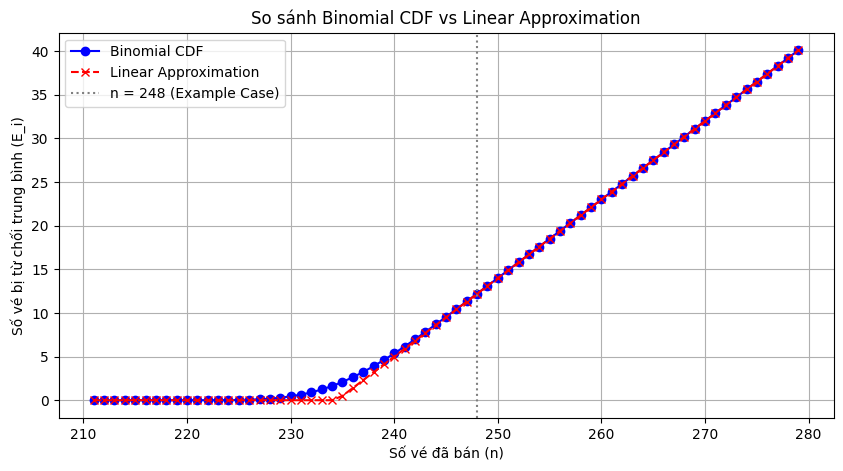

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

# --- Parameters ---
S = 211  # Số ghế có sẵn
p = 0.9  # Xác suất hành khách đến
n_values = np.arange(S, 280, 1)  # Thử nghiệm với số vé từ S đến 280
avg_comp = 6000000  # Mức bồi thường trung bình (VND)

# --- Function to Compute Expected Bumped Passengers ---
def expected_bumped_tickets(n, S, p):
    """Tính số hành khách bị từ chối theo Binomial CDF"""
    return sum(1 - binom.cdf(j - 1, n, p) for j in range(S + 1, n + 1))

def expected_bumped_linear(n, S, p):
    """Tính số hành khách bị từ chối theo mô hình tuyến tính"""
    return max(p * n - S, 0)

# --- Tính toán kết quả cho từng n ---
binomial_results = [expected_bumped_tickets(n, S, p) for n in n_values]
linear_results = [expected_bumped_linear(n, S, p) for n in n_values]

# --- Vẽ biểu đồ ---
plt.figure(figsize=(10, 5))
plt.plot(n_values, binomial_results, label="Binomial CDF", color='b', linestyle='-', marker='o')
plt.plot(n_values, linear_results, label="Linear Approximation", color='r', linestyle='--', marker='x')

# --- Tùy chỉnh biểu đồ ---
plt.axvline(x=248, color='gray', linestyle=':', label="n = 248 (Example Case)")
plt.xlabel("Số vé đã bán (n)")
plt.ylabel("Số vé bị từ chối trung bình (E_i)")
plt.title("So sánh Binomial CDF vs Linear Approximation")
plt.legend()
plt.grid(True)

# --- Hiển thị biểu đồ ---
plt.show()


# Bài toán cũ

In [5]:
import cvxpy as cp
import math
import numpy as np

# --------------------
# Parameters (Generalized)
# --------------------
# Ticket prices (in VND)
r_E1 = 2728000    # Economy Standard
r_E2 = 3582000    # Economy Flexible
r_S1 = 3957000    # Special Economy Standard
r_S2 = 4497000    # Special Economy Flexible
r_B1 = 5860000    # Business Standard

# Compensation amounts = 200% price + 400,000 VND
c_E1 = 2 * r_E1
c_E2 = 2 * r_E2
c_S1 = 2 * r_S1
c_S2 = 2 * r_S2
c_B1 = 2 * r_B1

# Seat capacities for each class
S_E = 211  # Economy
S_S = 35   # Special Economy
S_B = 28   # Business
S_total = S_E + S_S + S_B

# Overbooking factor (total tickets sold must be <= 120% of total seats)
alpha = 1.2
T_max = math.floor(alpha * S_total)

# Show-up probability
p = 0.85

# Minimum fraction for each fare level (25% of class capacity)
gamma = 0.25
min_E_level = math.ceil(gamma * S_E)  # 53
min_S_level = math.ceil(gamma * S_S)  # 9
min_B_level = math.ceil(gamma * S_B)  # 7

# Average compensation per class
bar_c_E = np.mean([c_E1, c_E2])
bar_c_S = np.mean([c_S1, c_S2])
bar_c_B = c_B1  # Only one level for Business

# --------------------
# Decision Variables
# --------------------
x_E1 = cp.Variable(integer=True, name="x_E1")
x_E2 = cp.Variable(integer=True, name="x_E2")
x_S1 = cp.Variable(integer=True, name="x_S1")
x_S2 = cp.Variable(integer=True, name="x_S2")
x_B1 = cp.Variable(integer=True, name="x_B1")
x_E = cp.Variable(integer=True, name="x_E")
x_S = cp.Variable(integer=True, name="x_S")
x_B = cp.Variable(integer=True, name="x_B")


# --------------------
# Revenue Function
# --------------------
revenue = (r_E1 * x_E1 + r_E2 * x_E2 +
           r_S1 * x_S1 + r_S2 * x_S2 +
           r_B1 * x_B1)

# --------------------
# Compensation Cost
# --------------------
over_E = cp.pos(p * x_E - S_E)
over_S = cp.pos(p * x_S - S_S)
over_B = cp.pos(p * x_B - S_B)

comp_cost_E = over_E * bar_c_E
comp_cost_S = over_S * bar_c_S
comp_cost_B = over_B * bar_c_B

total_comp_cost = comp_cost_E + comp_cost_S + comp_cost_B

# --------------------
# Profit Function (Objective)
# --------------------
profit = revenue - total_comp_cost

# --------------------
# Constraints
# --------------------
constraints = [
    x_E1 + x_E2 == x_E,
    x_S1 + x_S2 == x_S,
    x_B1 == x_B,

    x_E + x_S + x_B <= T_max,  # Tổng vé bán không vượt quá mức cho phép

    x_E >= S_E,  # Số vé bán phải lớn hơn hoặc bằng số ghế có sẵn
    x_S >= S_S,
    x_B >= S_B,

    x_E1 >= min_E_level,
    x_E2 >= min_E_level,
    x_S1 >= min_S_level,
    x_S2 >= min_S_level,
    x_B1 >= min_B_level,

    x_E1 >= 0, x_E2 >= 0,
    x_S1 >= 0, x_S2 >= 0,
    x_B1 >= 0
]

# --------------------
# Define the problem: maximize profit
# --------------------
problem = cp.Problem(cp.Maximize(profit), constraints)

# --------------------
# Solve the problem
# --------------------
result = problem.solve(solver=cp.GLPK_MI, verbose=True)

# --------------------
# Print results
# --------------------
print("Optimal Solution:")
print(f"  Economy Standard (x_E1): {x_E1.value}")
print(f"  Economy Flexible (x_E2): {x_E2.value}")
print(f"  Special Economy Standard (x_S1): {x_S1.value}")
print(f"  Special Economy Flexible (x_S2): {x_S2.value}")
print(f"  Business Standard (x_B1): {x_B1.value}")
print(f"  Total tickets sold: {x_E.value + x_S.value + x_B.value}")
print(f"  Expected Profit: {profit.value:,.0f} VND")

                                     CVXPY                                     
                                     v1.6.4                                    
(CVXPY) Apr 01 12:23:24 AM: Your problem has 8 variables, 17 constraints, and 0 parameters.
(CVXPY) Apr 01 12:23:24 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 01 12:23:24 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 01 12:23:24 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 01 12:23:24 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 01 12:23:24 AM: Compiling problem (target solver=GLPK_MI).
(

# **Approximation**

## MILP

### GLPK_MI (Branch and bound)

In [6]:
import cvxpy as cp
import math

# ====================
# 1. Các tham số
# ====================

# -- Giá vé (VND) --
r_E1 = 2728000  # Economy Standard
r_E2 = 3582000  # Economy Flexible
r_S1 = 3957000  # Special Economy Standard
r_S2 = 4497000  # Special Economy Flexible
r_B1 = 5860000  # Business Standard

# -- Bồi thường = 200% giá vé --
c_E1 = 2 * r_E1
c_E2 = 2 * r_E2
c_S1 = 2 * r_S1
c_S2 = 2 * r_S2
c_B1 = 2 * r_B1

# -- Sức chứa mỗi class --
S_E = 211  # Economy
S_S = 35   # Special Economy
S_B = 28   # Business
S_total = S_E + S_S + S_B

# Chia ghế theo % fare level:
# Economy Standard ~60%, Economy Flexible ~40%
S_E1 = math.floor(0.6 * S_E)  # ~60% of 211
S_E2 = S_E - S_E1             # ~40% còn lại

# Special Economy Standard ~60%, Flexible ~40%
S_S1 = math.floor(0.6 * S_S)  # ~60% of 35
S_S2 = S_S - S_S1

# Business chỉ có 1 fare level (Standard) = 100%
S_B1 = S_B

# -- Xác suất show-up từng fare level --
p_E1 = 0.9
p_E2 = 0.85
p_S1 = 0.9
p_S2 = 0.85
p_B1 = 0.9

# -- Hệ số overbooking --
alpha = 1.2
T_max = math.floor(alpha * S_total)

# ====================
# 2. Biến quyết định
# ====================
# Mỗi fare level là một biến
x_E1 = cp.Variable(integer=True, name="x_E1")
x_E2 = cp.Variable(integer=True, name="x_E2")
x_S1 = cp.Variable(integer=True, name="x_S1")
x_S2 = cp.Variable(integer=True, name="x_S2")
x_B1 = cp.Variable(integer=True, name="x_B1")

# Các biến tổng theo lớp
x_E = cp.Variable(integer=True, name="x_E")
x_S = cp.Variable(integer=True, name="x_S")
x_B = cp.Variable(integer=True, name="x_B")

# ====================
# 3. Hàm mục tiêu
# ====================

# 3.1 Revenue
revenue = (r_E1 * x_E1 + r_E2 * x_E2 +
           r_S1 * x_S1 + r_S2 * x_S2 +
           r_B1 * x_B1)

# 3.2 Compensation cost (theo "transformation model")
#    max{ p_l * x_l - S_l, 0 } * c_l cho từng fare level
over_E1 = cp.pos(p_E1 * x_E1 - S_E1)
over_E2 = cp.pos(p_E2 * x_E2 - S_E2)
over_S1 = cp.pos(p_S1 * x_S1 - S_S1)
over_S2 = cp.pos(p_S2 * x_S2 - S_S2)
over_B1 = cp.pos(p_B1 * x_B1 - S_B1)

comp_cost_E1 = over_E1 * c_E1
comp_cost_E2 = over_E2 * c_E2
comp_cost_S1 = over_S1 * c_S1
comp_cost_S2 = over_S2 * c_S2
comp_cost_B1 = over_B1 * c_B1

total_comp_cost = (comp_cost_E1 + comp_cost_E2 +
                   comp_cost_S1 + comp_cost_S2 +
                   comp_cost_B1)

# Hàm lợi nhuận (Profit)
profit = revenue - total_comp_cost

# ====================
# 4. Ràng buộc
# ====================
constraints = [
    x_E1 + x_E2 == x_E,
    x_S1 + x_S2 == x_S,
    x_B1 == x_B,

    # 4.1 Tổng vé bán không vượt quá alpha * tổng ghế
    x_E1 + x_E2 + x_S1 + x_S2 + x_B1 <= T_max,

    # 4.2 Mỗi fare level bán ít nhất sức chứa "chuẩn" (theo model x_il >= S_il)
    x_E1 >= S_E1,
    x_E2 >= S_E2,
    x_S1 >= S_S1,
    x_S2 >= S_S2,
    x_B1 >= S_B1,

    x_E1 >= 0, x_E2 >= 0,
    x_S1 >= 0, x_S2 >= 0,
    x_B1 >= 0
]

# ====================
# 5. Tạo và giải bài toán
# ====================
problem = cp.Problem(cp.Maximize(profit), constraints)
result = problem.solve(solver=cp.GLPK_MI, verbose=True)

# ====================
# 6. In kết quả
# ====================
print("=== Optimal Solution ===")
print("Xác suất p_E1:{}, p_E2:{},p_S1:{}, p_S2:{}, p_B1:{}".format(p_E1,p_E2,p_S1,p_S2,p_B1))
print(f" Economy Standard (x_E1): {x_E1.value}")
print(f" Economy Flexible (x_E2): {x_E2.value}")
print(f" Special Economy Standard (x_S1): {x_S1.value}")
print(f" Special Economy Flexible (x_S2): {x_S2.value}")
print(f" Business Standard (x_B1): {x_B1.value}")

total_tickets_sold = x_E1.value + x_E2.value + x_S1.value + x_S2.value + x_B1.value
print(f" Total tickets sold: {total_tickets_sold}")
print(f'Total compensation cost: {total_comp_cost.value:,.0f} VND')

print(f" Expected Profit: {profit.value:,.0f} VND")


                                     CVXPY                                     
                                     v1.6.4                                    
(CVXPY) Apr 01 12:23:24 AM: Your problem has 8 variables, 14 constraints, and 0 parameters.
(CVXPY) Apr 01 12:23:24 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 01 12:23:24 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 01 12:23:24 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 01 12:23:24 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 01 12:23:24 AM: Compiling problem (target solver=GLPK_MI).
(

### HIGHS (kết hợp các phương pháp LP hiện đại (dual simplex / interior point) với branch‐and‐bound)

In [7]:
import cvxpy as cp
import math

# ====================
# 1. Các tham số
# ====================

# -- Giá vé (VND) --
r_E1 = 2728000    # Economy Standard
r_E2 = 3582000    # Economy Flexible
r_S1 = 3957000    # Special Economy Standard
r_S2 = 4497000    # Special Economy Flexible
r_B1 = 5860000    # Business Standard

# -- Bồi thường = 200% giá vé --
c_E1 = 2 * r_E1
c_E2 = 2 * r_E2
c_S1 = 2 * r_S1
c_S2 = 2 * r_S2
c_B1 = 2 * r_B1

# -- Sức chứa mỗi class --
S_E = 211  # Economy
S_S = 35   # Special Economy
S_B = 28   # Business
S_total = S_E + S_S + S_B

# Chia ghế theo % fare level:
# Economy Standard ~60%, Economy Flexible ~40%
S_E1 = math.floor(0.6 * S_E)  # ~126
S_E2 = S_E - S_E1             # ~85

# Special Economy Standard ~60%, Special Economy Flexible ~40%
S_S1 = math.floor(0.6 * S_S)  # ~21
S_S2 = S_S - S_S1             # ~14

# Business chỉ có 1 fare level (Standard)
S_B1 = S_B

# -- Xác suất show-up từng fare level --
p_E1 = 0.9
p_E2 = 0.85
p_S1 = 0.9
p_S2 = 0.85
p_B1 = 0.9

# -- Hệ số overbooking --
alpha = 1.2
T_max = math.floor(alpha * S_total)

# ====================
# 2. Biến quyết định
# ====================
# Biến quyết định cho từng fare level
x_E1 = cp.Variable(integer=True, name="x_E1")
x_E2 = cp.Variable(integer=True, name="x_E2")
x_S1 = cp.Variable(integer=True, name="x_S1")
x_S2 = cp.Variable(integer=True, name="x_S2")
x_B1 = cp.Variable(integer=True, name="x_B1")

# Biến tổng theo lớp
x_E = cp.Variable(integer=True, name="x_E")
x_S = cp.Variable(integer=True, name="x_S")
x_B = cp.Variable(integer=True, name="x_B")

# ====================
# 3. Hàm mục tiêu
# ====================
# Doanh thu
revenue = (r_E1 * x_E1 + r_E2 * x_E2 +
           r_S1 * x_S1 + r_S2 * x_S2 +
           r_B1 * x_B1)

# Chi phí bump (xấp xỉ theo công thức: max{p*x - S, 0})
over_E1 = cp.pos(p_E1 * x_E1 - S_E1)
over_E2 = cp.pos(p_E2 * x_E2 - S_E2)
over_S1 = cp.pos(p_S1 * x_S1 - S_S1)
over_S2 = cp.pos(p_S2 * x_S2 - S_S2)
over_B1 = cp.pos(p_B1 * x_B1 - S_B1)

comp_cost_E1 = over_E1 * c_E1
comp_cost_E2 = over_E2 * c_E2
comp_cost_S1 = over_S1 * c_S1
comp_cost_S2 = over_S2 * c_S2
comp_cost_B1 = over_B1 * c_B1

total_comp_cost = comp_cost_E1 + comp_cost_E2 + comp_cost_S1 + comp_cost_S2 + comp_cost_B1

# Lợi nhuận
profit = revenue - total_comp_cost

# ====================
# 4. Ràng buộc
# ====================
constraints = [
    # Liên kết các biến theo lớp:
    x_E1 + x_E2 == x_E,
    x_S1 + x_S2 == x_S,
    x_B1 == x_B,

    # Tổng vé bán không vượt quá T_max
    x_E + x_S + x_B <= T_max,

    # Mỗi fare level bán ít nhất sức chứa "chuẩn":
    x_E1 >= S_E1,
    x_E2 >= S_E2,
    x_S1 >= S_S1,
    x_S2 >= S_S2,
    x_B1 >= S_B1,

    # Ràng buộc không âm (trong trường hợp cần thiết)
    x_E1 >= 0, x_E2 >= 0,
    x_S1 >= 0, x_S2 >= 0,
    x_B1 >= 0
]

# ====================
# 5. Tạo và giải bài toán
# ====================
problem = cp.Problem(cp.Maximize(profit), constraints)

result = problem.solve(solver='HIGHS', verbose=True)

print("=== Optimal Solution ===")
print(f"Economy Standard (x_E1): {x_E1.value}")
print(f"Economy Flexible (x_E2): {x_E2.value}")
print(f"Special Economy Standard (x_S1): {x_S1.value}")
print(f"Special Economy Flexible (x_S2): {x_S2.value}")
print(f"Business Standard (x_B1): {x_B1.value}")

total_tickets = x_E.value + x_S.value + x_B.value
print(f"Total tickets sold: {total_tickets}")
print(f"Expected Profit: {profit.value:,.0f} VND")


                                     CVXPY                                     
                                     v1.6.4                                    
(CVXPY) Apr 01 12:23:24 AM: Your problem has 8 variables, 14 constraints, and 0 parameters.
(CVXPY) Apr 01 12:23:24 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 01 12:23:24 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 01 12:23:24 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 01 12:23:24 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 01 12:23:24 AM: Compiling problem (target solver=HIGHS).
(CV

### SCIPY (giống HIGHS)

In [8]:
import cvxpy as cp
print("CVXPY version:", cp.__version__)
print("Installed solvers:", cp.installed_solvers())


CVXPY version: 1.6.4
Installed solvers: ['CBC', 'CLARABEL', 'CVXOPT', 'GLOP', 'GLPK', 'GLPK_MI', 'GUROBI', 'HIGHS', 'MOSEK', 'OSQP', 'PDLP', 'SCIP', 'SCIPY', 'SCS', 'XPRESS']


In [9]:
import cvxpy as cp
import math

# ====================
# 1. Các tham số
# ====================

# -- Giá vé (VND) --
r_E1 = 2728000    # Economy Standard
r_E2 = 3582000    # Economy Flexible
r_S1 = 3957000    # Special Economy Standard
r_S2 = 4497000    # Special Economy Flexible
r_B1 = 5860000    # Business Standard

# -- Bồi thường = 200% giá vé --
c_E1 = 2 * r_E1
c_E2 = 2 * r_E2
c_S1 = 2 * r_S1
c_S2 = 2 * r_S2
c_B1 = 2 * r_B1

# -- Sức chứa mỗi class --
S_E = 211  # Economy
S_S = 35   # Special Economy
S_B = 28   # Business
S_total = S_E + S_S + S_B

# Chia ghế theo % fare level:
# Economy Standard ~60%, Economy Flexible ~40%
S_E1 = math.floor(0.6 * S_E)  # ~126
S_E2 = S_E - S_E1             # ~85

# Special Economy Standard ~60%, Special Economy Flexible ~40%
S_S1 = math.floor(0.6 * S_S)  # ~21
S_S2 = S_S - S_S1             # ~14

# Business chỉ có 1 fare level (Standard)
S_B1 = S_B

# -- Xác suất show-up từng fare level --
p_E1 = 0.9
p_E2 = 0.85
p_S1 = 0.9
p_S2 = 0.85
p_B1 = 0.9

# -- Hệ số overbooking --
alpha = 1.2
T_max = math.floor(alpha * S_total)

# ====================
# 2. Biến quyết định
# ====================
# Biến quyết định cho từng fare level
x_E1 = cp.Variable(integer=True, name="x_E1")
x_E2 = cp.Variable(integer=True, name="x_E2")
x_S1 = cp.Variable(integer=True, name="x_S1")
x_S2 = cp.Variable(integer=True, name="x_S2")
x_B1 = cp.Variable(integer=True, name="x_B1")

# Biến tổng theo lớp
x_E = cp.Variable(integer=True, name="x_E")
x_S = cp.Variable(integer=True, name="x_S")
x_B = cp.Variable(integer=True, name="x_B")

# ====================
# 3. Hàm mục tiêu
# ====================
# Doanh thu
revenue = (r_E1 * x_E1 + r_E2 * x_E2 +
           r_S1 * x_S1 + r_S2 * x_S2 +
           r_B1 * x_B1)

# Chi phí bump (xấp xỉ theo công thức: max{p*x - S, 0})
over_E1 = cp.pos(p_E1 * x_E1 - S_E1)
over_E2 = cp.pos(p_E2 * x_E2 - S_E2)
over_S1 = cp.pos(p_S1 * x_S1 - S_S1)
over_S2 = cp.pos(p_S2 * x_S2 - S_S2)
over_B1 = cp.pos(p_B1 * x_B1 - S_B1)

comp_cost_E1 = over_E1 * c_E1
comp_cost_E2 = over_E2 * c_E2
comp_cost_S1 = over_S1 * c_S1
comp_cost_S2 = over_S2 * c_S2
comp_cost_B1 = over_B1 * c_B1

total_comp_cost = comp_cost_E1 + comp_cost_E2 + comp_cost_S1 + comp_cost_S2 + comp_cost_B1

# Lợi nhuận
profit = revenue - total_comp_cost

# ====================
# 4. Ràng buộc
# ====================
constraints = [
    # Liên kết các biến theo lớp:
    x_E1 + x_E2 == x_E,
    x_S1 + x_S2 == x_S,
    x_B1 == x_B,

    # Tổng vé bán không vượt quá T_max
    x_E + x_S + x_B <= T_max,

    # Mỗi fare level bán ít nhất sức chứa "chuẩn":
    x_E1 >= S_E1,
    x_E2 >= S_E2,
    x_S1 >= S_S1,
    x_S2 >= S_S2,
    x_B1 >= S_B1,

    # Ràng buộc không âm (trong trường hợp cần thiết)
    x_E1 >= 0, x_E2 >= 0,
    x_S1 >= 0, x_S2 >= 0,
    x_B1 >= 0
]

# ====================
# 5. Tạo và giải bài toán
# ====================
problem = cp.Problem(cp.Maximize(profit), constraints)

result = problem.solve(solver='SCIPY', verbose=True)

print("=== Optimal Solution ===")
print(f"Economy Standard (x_E1): {x_E1.value}")
print(f"Economy Flexible (x_E2): {x_E2.value}")
print(f"Special Economy Standard (x_S1): {x_S1.value}")
print(f"Special Economy Flexible (x_S2): {x_S2.value}")
print(f"Business Standard (x_B1): {x_B1.value}")

total_tickets = x_E.value + x_S.value + x_B.value
print(f"Total tickets sold: {total_tickets}")
print(f"Expected Profit: {profit.value:,.0f} VND")


                                     CVXPY                                     
                                     v1.6.4                                    
(CVXPY) Apr 01 12:23:24 AM: Your problem has 8 variables, 14 constraints, and 0 parameters.
(CVXPY) Apr 01 12:23:24 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 01 12:23:24 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 01 12:23:24 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 01 12:23:24 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 01 12:23:24 AM: Compiling problem (target solver=SCIPY).
(CV

## GA

In [10]:
import math
import random
import numpy as np

# DEAP cho GA
from deap import base, creator, tools

# ============================
# 1. Tham số mô hình
# ============================

# Giá vé (VND)
r_E1 = 2728000  # Economy Standard
r_E2 = 3582000  # Economy Flexible
r_S1 = 3957000  # Special Economy Standard
r_S2 = 4497000  # Special Economy Flexible
r_B1 = 5860000  # Business Standard

# Bồi thường = 200% giá vé
c_E1 = 2 * r_E1
c_E2 = 2 * r_E2
c_S1 = 2 * r_S1
c_S2 = 2 * r_S2
c_B1 = 2 * r_B1

# Số ghế mỗi class
S_E = 211
S_S = 35
S_B = 28
S_total = S_E + S_S + S_B

# Phân bổ ghế cho từng fare level (60%-40% / 60%-40% / 100%)
S_E1 = math.floor(0.6 * S_E)   # Economy Standard
S_E2 = S_E - S_E1              # Economy Flexible
S_S1 = math.floor(0.6 * S_S)   # Special Econ. Standard
S_S2 = S_S - S_S1              # Special Econ. Flexible
S_B1 = S_B                     # Business Standard

S_levels = [S_E1, S_E2, S_S1, S_S2, S_B1]

# Xác suất show-up
p_E1 = 0.9
p_E2 = 0.85
p_S1 = 0.9
p_S2 = 0.85
p_B1 = 0.9
p_levels = [p_E1, p_E2, p_S1, p_S2, p_B1]

# Giá vé
r_levels = [r_E1, r_E2, r_S1, r_S2, r_B1]

# Bồi thường
c_levels = [c_E1, c_E2, c_S1, c_S2, c_B1]

# Overbooking factor
alpha = 1.2
T_max = math.floor(alpha * S_total)  # Tổng vé bán <= T_max

N_FARE = 5  # 5 fare level: E1, E2, S1, S2, B1

# ============================
# 2. Hàm tính lợi nhuận
# ============================
def compute_profit(x_list):
    """
    x_list: [x_E1, x_E2, x_S1, x_S2, x_B1] (đảm bảo đã repair, sum <= T_max, x_l >= S_l)
    Return: profit (float)
    """
    # Tính revenue
    revenue = 0
    for i in range(N_FARE):
        revenue += r_levels[i] * x_list[i]

    # Tính chi phí bump: sum( c_l * max(p_l * x_l - S_l, 0) )
    comp_cost = 0
    for i in range(N_FARE):
        overshoot = p_levels[i] * x_list[i] - S_levels[i]
        if overshoot > 0:
            comp_cost += c_levels[i] * overshoot

    return revenue - comp_cost

# ============================
# 3. Hàm Repair cá thể
# ============================
def repair_ind(ind):
    """
    Sửa cá thể ind (list 5 gene) để thỏa mãn:
      1) x_l >= S_l
      2) sum(x_l) <= T_max
    """
    # Bước 1: Đảm bảo x_l >= S_l
    for i in range(N_FARE):
        if ind[i] < S_levels[i]:
            ind[i] = S_levels[i]

    # Bước 2: Đảm bảo tổng <= T_max (nếu vượt, ta scale xuống)
    total = sum(ind)
    if total > T_max:
        ratio = T_max / float(total)
        # scale x_l về S_l + ratio*(x_l - S_l)
        for i in range(N_FARE):
            base_val = S_levels[i]
            diff = ind[i] - base_val
            new_val = base_val + ratio * diff
            ind[i] = int(round(new_val))
        # có thể lặp lại check do int(round()) gây sai khác
        # ta lặp đến khi sum <= T_max hẳn
        # (Nhưng thường 1 lần đủ.)
        while sum(ind) > T_max:
            # Nếu vẫn > T_max, giảm dần
            exceed = sum(ind) - T_max
            # Chia đều exceed
            for i in range(N_FARE):
                if ind[i] > S_levels[i]:
                    reduce_amt = min(exceed, ind[i] - S_levels[i])
                    ind[i] -= reduce_amt
                    exceed -= reduce_amt
                    if exceed <= 0:
                        break

    return ind

# ============================
# 4. Cấu trúc GA với DEAP
# ============================
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# 4.1 Khởi tạo gene
def random_gene(i):
    """Gene i random trong [S_levels[i], T_max]."""
    return random.randint(S_levels[i], T_max)

def init_ind():
    """Khởi tạo 1 cá thể gồm 5 gene."""
    ind = [random_gene(i) for i in range(N_FARE)]
    # repair để đảm bảo feasible
    ind = repair_ind(ind)
    return ind

toolbox.register("individual", tools.initIterate, creator.Individual, init_ind)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# 4.2 Hàm đánh giá (evaluate)
def eval_ind(ind):
    # Đảm bảo cá thể hợp lệ
    repair_ind(ind)
    # Tính profit
    profit = compute_profit(ind)
    return (profit,)

toolbox.register("evaluate", eval_ind)

# 4.3 Crossover & Mutation
# - crossover: trao đổi gene với xác suất 0.5
toolbox.register("mate", tools.cxUniform, indpb=0.5)

# - mutation: random lại gene với prob=0.2
def mut_uniform_custom(individual, indpb=0.2):
    for i in range(len(individual)):
        if random.random() < indpb:
            individual[i] = random.randint(S_levels[i], T_max)
    # repair
    repair_ind(individual)
    return (individual,)

toolbox.register("mutate", mut_uniform_custom, indpb=0.2)

# 4.4 Selection
toolbox.register("select", tools.selTournament, tournsize=3)

# ============================
# 5. Vòng lặp tiến hóa
# ============================
def run_ga(n_gen=50, pop_size=50):
    # Khởi tạo quần thể
    pop = toolbox.population(n=pop_size)

    # Tính fitness ban đầu
    for ind in pop:
        ind.fitness.values = toolbox.evaluate(ind)

    for gen in range(n_gen):
        # Chọn cá thể (offspring)
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        # Lai ghép
        for i in range(0, len(offspring)-1, 2):
            if random.random() < 0.7:  # prob crossover
                toolbox.mate(offspring[i], offspring[i+1])
                del offspring[i].fitness.values
                del offspring[i+1].fitness.values

        # Đột biến
        for mutant in offspring:
            if random.random() < 0.3:  # prob mutation
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Tính lại fitness cho cá thể mới
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        for ind in invalid_ind:
            ind.fitness.values = toolbox.evaluate(ind)

        # Tạo quần thể thế hệ kế
        pop[:] = offspring

        # Thống kê
        fits = [ind.fitness.values[0] for ind in pop]
        best_fit = max(fits)
        avg_fit = sum(fits)/len(fits)
        print(f"Gen {gen+1}: Best={best_fit:,.0f} | Avg={avg_fit:,.0f}")

    # Kết thúc
    best_ind = tools.selBest(pop, 1)[0]
    return best_ind, best_ind.fitness.values[0]

# ============================
# 6. Chạy & In kết quả
# ============================
if __name__ == "__main__":
    random.seed(0)  # Cố định seed
    best_ind, best_profit = run_ga(n_gen=50, pop_size=50)

    print("\n===== KẾT QUẢ CUỐI CÙNG =====")
    print("Best Individual:", best_ind)
    print(f"Best Profit: {best_profit:,.0f} VND")

    print("\nChi tiết phân bổ vé:")
    print(f"  Economy Standard (x_E1): {best_ind[0]}")
    print(f"  Economy Flexible (x_E2): {best_ind[1]}")
    print(f"  Special Econ Standard (x_S1): {best_ind[2]}")
    print(f"  Special Econ Flexible (x_S2): {best_ind[3]}")
    print(f"  Business Standard (x_B1): {best_ind[4]}")
    print(f"  Total tickets sold: {sum(best_ind)}")


Gen 1: Best=923,042,800 | Avg=823,462,624
Gen 2: Best=958,312,900 | Avg=853,773,742
Gen 3: Best=988,401,700 | Avg=875,656,980
Gen 4: Best=988,401,700 | Avg=916,772,476
Gen 5: Best=1,013,584,900 | Avg=926,826,892
Gen 6: Best=1,013,584,900 | Avg=954,946,036
Gen 7: Best=1,042,163,100 | Avg=981,282,674
Gen 8: Best=1,043,592,900 | Avg=977,905,052
Gen 9: Best=1,059,761,900 | Avg=998,301,196
Gen 10: Best=1,059,761,900 | Avg=996,211,472
Gen 11: Best=1,059,761,900 | Avg=1,030,210,600
Gen 12: Best=1,061,056,900 | Avg=991,102,242
Gen 13: Best=1,070,432,900 | Avg=1,000,813,918
Gen 14: Best=1,075,120,900 | Avg=1,041,206,564
Gen 15: Best=1,075,912,300 | Avg=1,035,319,802
Gen 16: Best=1,075,912,300 | Avg=1,008,049,578
Gen 17: Best=1,075,912,300 | Avg=1,054,235,754
Gen 18: Best=1,075,912,300 | Avg=1,034,651,782
Gen 19: Best=1,075,912,300 | Avg=1,040,919,196
Gen 20: Best=1,075,912,300 | Avg=1,019,525,528
Gen 21: Best=1,075,912,300 | Avg=1,027,419,604
Gen 22: Best=1,075,912,300 | Avg=1,026,014,634
Gen 2

## Lagrangian Relaxation Approach

In [11]:
import math
import random

# =========================
# 1. THAM SỐ MÔ HÌNH
# =========================

classes_data = {
    "E": {
        "fare_levels": ["E1","E2"],
        "r": [2728000, 3582000],        # giá vé
        "c": [2*2728000, 2*3582000],    # bồi thường 200%
        "p": [0.9, 0.85],
        "S": [126, 85]  # Economy Standard=126, Flexible=85
    },
    "S": {
        "fare_levels": ["S1","S2"],
        "r": [3957000, 4497000],
        "c": [2*3957000, 2*4497000],
        "p": [0.9, 0.85],
        "S": [21, 14]  # Special Standard=21, Flexible=14
    },
    "B": {
        "fare_levels": ["B1"],
        "r": [5860000],
        "c": [2*5860000],
        "p": [0.9],
        "S": [28]
    }
}

# Tính tổng seat
S_total = sum(sum(cls["S"]) for cls in classes_data.values())
alpha = 1.2
T_max = math.floor(alpha * S_total)

# =========================
# 2. HÀM TÍNH PROFIT GỐC
# =========================
def actual_profit(allocation):
    """
    allocation: dict => {
      "E": [x_E1, x_E2],
      "S": [x_S1, x_S2],
      "B": [x_B1]
    }
    Tính sum(r*x) - sum(c*max(p*x - S,0)) trên tất cả class.
    """
    total_rev = 0
    total_cost = 0
    for cls_name, cls_data in classes_data.items():
        x_list = allocation[cls_name]
        r_list = cls_data["r"]
        c_list = cls_data["c"]
        p_list = cls_data["p"]
        S_list = cls_data["S"]

        for i in range(len(x_list)):
            xi = x_list[i]
            total_rev += r_list[i]*xi
            overshoot = p_list[i]*xi - S_list[i]
            if overshoot>0:
                total_cost += c_list[i]*overshoot
    return total_rev - total_cost

# =========================
# 3. LAGRANGIAN SUBPROBLEM
# =========================
def solve_subproblem_for_class(cls_data, lam, n_rand=1000):
    """
    Giải subproblem cho 1 class i, max:
      sum( (r_i,l + lam) * x_i,l ) - sum( c_i,l * max(p_i,l*x_i,l - S_i,l, 0 ) )
    ràng buộc x_i,l >= S_i,l, x_i,l int
    => random search
    Trả về best_x (list) & best_val
    """
    r_list = cls_data["r"]
    c_list = cls_data["c"]
    p_list = cls_data["p"]
    S_list = cls_data["S"]
    n_levels = len(r_list)

    best_x = None
    best_val = -1e15

    for _ in range(n_rand):
        x_candidate = []
        for i in range(n_levels):
            low = S_list[i]
            high = T_max  # random upper
            xi = random.randint(low, high)
            x_candidate.append(xi)

        val = 0
        # Tính: sum((r+lam)*x) - sum(c*max(p*x-S,0))
        # => sum(r_i,l*x_i,l) + lam*sum(x_i,l) - ...
        sum_x = 0
        rev = 0
        cost = 0
        for i in range(n_levels):
            xi = x_candidate[i]
            rev += r_list[i]*xi
            sum_x += xi
            overshoot = p_list[i]*xi - S_list[i]
            if overshoot>0:
                cost += c_list[i]*overshoot
        val = rev - cost + lam*sum_x

        if val>best_val:
            best_val = val
            best_x = x_candidate[:]

    return best_x, best_val

def solve_all_subproblems(lam):
    """
    Giải subproblem cho từng class (E,S,B), rồi gộp lại
    Trả về allocation = { "E": [x_E1,x_E2], "S":..., "B":... }
         & sum of Lagrangian values (trừ đi lam*T_max).
    """
    total_L = 0
    allocation = {}
    for cls_name, cls_data in classes_data.items():
        x_star, val_star = solve_subproblem_for_class(cls_data, lam, n_rand=1000)
        allocation[cls_name] = x_star
        total_L += val_star

    # L(x, lam) = sum(subproblem) - lam*T_max
    total_L -= lam*T_max
    return allocation, total_L

def sum_of_all_tickets(allocation):
    s=0
    for cls_name, x_list in allocation.items():
        s+= sum(x_list)
    return s

# =========================
# 4. SUBGRADIENT METHOD
# =========================
def lagrangian_decomposition(max_iter=30, step_init=5000.0):
    lam = 0.0
    best_feasible_allocation = None
    best_feasible_profit = -1e15

    for k in range(max_iter):
        # 1) Giải tất cả subproblem (mỗi class 1 subproblem)
        allocation, L_val = solve_all_subproblems(lam)
        sumX = sum_of_all_tickets(allocation)

        # 2) Tính subgradient = sumX - T_max
        subgrad = sumX - T_max

        # 3) Cập nhật lambda
        step_k = step_init / math.sqrt(k+1)
        lam_new = lam + step_k * subgrad
        lam = max(0, lam_new)

        # 4) Kiểm tra feasibility
        if sumX <= T_max:
            # Tính profit gốc
            pft = actual_profit(allocation)
            if pft>best_feasible_profit:
                best_feasible_profit = pft
                best_feasible_allocation = allocation

        # In log
        print(f"Iter {k+1:2d}: L_val= {L_val:,.0f}, lam= {lam:,.2f}, sumX= {sumX}, best_feas= {best_feasible_profit:,.0f}")

    return best_feasible_allocation, best_feasible_profit, lam

# =========================
# 5. CHẠY THỬ
# =========================
if __name__=="__main__":
    random.seed(0)
    alloc_best, prof_best, lam_final = lagrangian_decomposition(max_iter=30, step_init=5000.0)

    print("\n=== KẾT QUẢ CUỐI CÙNG ===")
    print("Lambda cuối:", lam_final)
    if alloc_best is not None:
        print("Best feasible allocation:", alloc_best)
        sum_x = sum_of_all_tickets(alloc_best)
        print(f" -> sum(x) = {sum_x} (<= {T_max})")
        print(f" -> Profit = {prof_best:,.0f} VND")
    else:
        print("Không tìm thấy nghiệm khả thi!")

Iter  1: L_val= 1,042,509,200, lam= 0.00, sumX= 318, best_feas= 1,042,509,200
Iter  2: L_val= 1,017,758,600, lam= 0.00, sumX= 327, best_feas= 1,042,509,200
Iter  3: L_val= 1,053,760,900, lam= 0.00, sumX= 305, best_feas= 1,053,760,900
Iter  4: L_val= 1,034,886,700, lam= 7,500.00, sumX= 331, best_feas= 1,053,760,900
Iter  5: L_val= 1,032,305,800, lam= 7,500.00, sumX= 328, best_feas= 1,053,760,900
Iter  6: L_val= 1,038,208,100, lam= 0.00, sumX= 323, best_feas= 1,053,760,900
Iter  7: L_val= 1,067,820,800, lam= 0.00, sumX= 308, best_feas= 1,067,820,800
Iter  8: L_val= 1,024,773,400, lam= 0.00, sumX= 328, best_feas= 1,067,820,800
Iter  9: L_val= 1,062,011,000, lam= 0.00, sumX= 314, best_feas= 1,067,820,800
Iter 10: L_val= 1,047,307,000, lam= 0.00, sumX= 320, best_feas= 1,067,820,800
Iter 11: L_val= 1,045,741,600, lam= 0.00, sumX= 322, best_feas= 1,067,820,800
Iter 12: L_val= 1,056,444,400, lam= 0.00, sumX= 320, best_feas= 1,067,820,800
Iter 13: L_val= 1,051,019,900, lam= 0.00, sumX= 313, bes

Iter 19: L_val= 1,030,555,400, lam= 0.00, sumX= 327, best_feas= 1,071,814,200
Iter 20: L_val= 1,050,954,900, lam= 0.00, sumX= 323, best_feas= 1,071,814,200
Iter 21: L_val= 1,064,610,300, lam= 0.00, sumX= 314, best_feas= 1,071,814,200
Iter 22: L_val= 1,040,835,500, lam= 0.00, sumX= 320, best_feas= 1,071,814,200
Iter 23: L_val= 1,075,359,800, lam= 0.00, sumX= 310, best_feas= 1,075,359,800
Iter 24: L_val= 1,043,436,000, lam= 0.00, sumX= 313, best_feas= 1,075,359,800
Iter 25: L_val= 1,056,475,000, lam= 0.00, sumX= 317, best_feas= 1,075,359,800
Iter 26: L_val= 1,056,947,200, lam= 0.00, sumX= 321, best_feas= 1,075,359,800
Iter 27: L_val= 1,043,446,700, lam= 0.00, sumX= 321, best_feas= 1,075,359,800
Iter 28: L_val= 1,067,521,000, lam= 0.00, sumX= 304, best_feas= 1,075,359,800
Iter 29: L_val= 984,174,500, lam= 17,641.06, sumX= 347, best_feas= 1,075,359,800
Iter 30: L_val= 1,036,216,759, lam= 16,728.19, sumX= 327, best_feas= 1,075,359,800

=== KẾT QUẢ CUỐI CÙNG ===
Lambda cuối: 16728.1861976446

## Weighted sum method

### Hội tụ

In [12]:
import pulp

def solve_airline_overbooking_MOO_with_constraints():
    """
    Ví dụ code: thêm ràng buộc x_{i,l} <= S_{i,l} và
    tổng vé bán <= alpha * tổng ghế,
    kèm mô hình multiobjective (doanh thu - beta*bồi thường).
    """
    # ---------------------------
    # 1. Định nghĩa tập (i,l)
    # ---------------------------
    # Ta đặt tên key là chuỗi, ví dụ: ('E','1'), ('E','2'), ...
    fare_types = [('E','1'), ('E','2'),
                  ('S','1'), ('S','2'),
                  ('B','1')]

    # ---------------------------
    # 2. Tham số
    # ---------------------------
    # Giá vé r_{i,l}
    r = {
        ('E','1'): 2728000,  # Economy Standard
        ('E','2'): 3582000,  # Economy Flexible
        ('S','1'): 3957000,  # Special Economy Standard
        ('S','2'): 4497000,  # Special Economy Flexible
        ('B','1'): 5860000   # Business Standard
    }

    # Xác suất xuất hiện p_{i,l}
    p = {
        ('E','1'): 0.9,
        ('E','2'): 0.85,
        ('S','1'): 0.9,
        ('S','2'): 0.85,
        ('B','1'): 0.9
    }

    # Sức chứa (hoặc giới hạn) cho từng (i,l)
    # Giả sử:
    #   Economy: 211 ghế, chia 60% Standard, 40% Flexible => (E,1)=126, (E,2)=84
    #   Special Economy: 35 ghế, chia 60%-40% => (S,1)=21, (S,2)=14
    #   Business: 28 ghế => (B,1)=28
    S_cap = {
        ('E','1'): 126,
        ('E','2'): 84,
        ('S','1'): 21,
        ('S','2'): 14,
        ('B','1'): 28
    }

    # Tổng ghế
    S_total = sum(S_cap.values())

    # Chi phí bồi thường = 200% giá vé
    c = {k: 2*r[k] for k in fare_types}

    # Hệ số overbooking alpha
    alpha = 1.2

    # ---------------------------
    # 3. Hàm con: Giải max [f(x) - beta*g(x)]
    # ---------------------------
    def solve_subproblem(beta):
        """
        Bài toán con:
          max  sum(r_{i,l} * x_{i,l}) - beta * sum(c_{i,l} * b_{i,l})
        s.t.
          x_{i,l} <= S_{i,l}                 (mới thêm)
          sum_{(i,l)} x_{i,l} <= alpha * sum_{(i,l)} S_{i,l}
          b_{i,l} >= p_{i,l}*x_{i,l} - S_{i,l}
          b_{i,l} >= 0
          x_{i,l} >= 0 và nguyên
        """
        prob = pulp.LpProblem("Overbooking_Subproblem", pulp.LpMaximize)

        # Tạo biến quyết định
        x = {k: pulp.LpVariable(f"x_{k[0]}{k[1]}",
                                lowBound=0, cat=pulp.LpInteger)
             for k in fare_types}
        b = {k: pulp.LpVariable(f"b_{k[0]}{k[1]}",
                                lowBound=0, cat=pulp.LpContinuous)
             for k in fare_types}

        # Hàm mục tiêu
        revenue_part = pulp.lpSum(r[k] * x[k] for k in fare_types)
        compcost_part = pulp.lpSum(c[k] * b[k] for k in fare_types)
        prob += revenue_part - beta*compcost_part

        # Ràng buộc: mỗi (i,l) không vượt capacity gốc
        for k in fare_types:
            prob += x[k] >= S_cap[k]

        # Ràng buộc: tổng vé bán <= alpha * tổng ghế
        prob += pulp.lpSum([x[k] for k in fare_types]) <= alpha * S_total

        # Ràng buộc b_{i,l} >= p_{i,l}*x_{i,l} - S_{i,l}
        for k in fare_types:
            prob += b[k] >= p[k]*x[k] - S_cap[k]
            prob += b[k] >= 0

        # Giải
        prob.solve(pulp.PULP_CBC_CMD(msg=0))

        # Lấy nghiệm
        x_sol = {k: x[k].varValue for k in fare_types}
        b_sol = {k: b[k].varValue for k in fare_types}
        return x_sol, b_sol

    # ---------------------------
    # 4. Tính f(x), g(x)
    # ---------------------------
    def compute_fg(x_sol):
        # f(x) = sum(r_{i,l} * x_{i,l})
        f_val = sum(r[k] * x_sol[k] for k in fare_types)
        # g(x) = sum(c_{i,l} * max(p_{i,l}*x_{i,l} - S_{i,l}, 0))
        g_val = 0
        for k in fare_types:
            bumped = max(p[k]*x_sol[k] - S_cap[k], 0)
            g_val += c[k]*bumped
        return f_val, g_val

    # ---------------------------
    # 5. Vòng lặp cập nhật beta
    # ---------------------------
    max_iter = 20
    beta = 0.0  # Khởi tạo

    for it in range(max_iter):
        x_sol, b_sol = solve_subproblem(beta)
        f_val, g_val = compute_fg(x_sol)

        # Tính sub_obj = f(x) - beta*g(x)
        sub_obj = f_val - beta*g_val

         # In kết quả vòng lặp
        print(f"--- Iteration {it} ---")
        print(f"beta = {beta:.6f}")
        print(f"f_val = {f_val:,.0f}")
        print(f"g_val = {g_val:,.0f}")
        print(f"sub_obj = {sub_obj:,.0f} (f - beta*g)")

        if g_val > 1e-9:
            new_beta = f_val / g_val
        else:
            # Nếu g_val=0 => dừng sớm (không phải bồi thường)
            print(f"Iteration {it+1}: g_val=0 => dừng.")
            break

        if abs(new_beta - beta) < 1e-6:
            beta = new_beta
            break
        beta = new_beta

    # Lấy nghiệm cuối
    f_final, g_final = compute_fg(x_sol)
    print("===== Kết quả cuối cùng =====")
    print(f"  beta = {beta}")
    print("  Nghiệm x_{i,l}:")
    for k in fare_types:
        print(f"    x_{k} = {x_sol[k]:.2f}")
    print(f"  Tổng vé bán = {sum(x_sol.values()):.2f}")
    print(f"  Doanh thu f(x) = {f_final:,.0f} VND")
    print(f"  Bồi thường g(x) = {g_final:,.0f} VND")
    print(f"  Lợi nhuận (f-g) = {f_final - g_final:,.0f} VND")

# Chạy thử
solve_airline_overbooking_MOO_with_constraints()


--- Iteration 0 ---
beta = 0.000000
f_val = 1,271,191,000
g_val = 536,776,000
sub_obj = 1,271,191,000 (f - beta*g)
--- Iteration 1 ---
beta = 2.368196
f_val = 1,081,161,000
g_val = 1,074,600
sub_obj = 1,078,616,136 (f - beta*g)
--- Iteration 2 ---
beta = 1006.105528
f_val = 1,077,579,000
g_val = 0
sub_obj = 1,077,579,000 (f - beta*g)
Iteration 3: g_val=0 => dừng.
===== Kết quả cuối cùng =====
  beta = 1006.1055276382481
  Nghiệm x_{i,l}:
    x_('E', '1') = 140.00
    x_('E', '2') = 98.00
    x_('S', '1') = 23.00
    x_('S', '2') = 16.00
    x_('B', '1') = 31.00
  Tổng vé bán = 308.00
  Doanh thu f(x) = 1,077,579,000 VND
  Bồi thường g(x) = 0 VND
  Lợi nhuận (f-g) = 1,077,579,000 VND


### Optimal point: f(x) - beta*g(x) ~ 0

In [13]:
import pulp

def solve_airline_overbooking_MOO_with_print():
    """
    Chạy đúng 10 vòng lặp (hoặc dừng sớm nếu f(x)-beta*g(x)=0),
    in kết quả mỗi vòng,
    và lưu nghiệm tốt nhất (theo hàm mục tiêu con) để in cuối cùng.
    """
    # ---------------------------
    # 1. Định nghĩa tập (i,l)
    # ---------------------------
    fare_types = [('E','1'), ('E','2'),
                  ('S','1'), ('S','2'),
                  ('B','1')]

    # ---------------------------
    # 2. Tham số
    # ---------------------------
    r = {
        ('E','1'): 2728000,  # Economy Standard
        ('E','2'): 3582000,  # Economy Flexible
        ('S','1'): 3957000,  # Special Economy Standard
        ('S','2'): 4497000,  # Special Economy Flexible
        ('B','1'): 5860000   # Business Standard
    }

    p = {
        ('E','1'): 0.9,
        ('E','2'): 0.85,
        ('S','1'): 0.9,
        ('S','2'): 0.85,
        ('B','1'): 0.9
    }

    # Sức chứa "cứng" cho từng loại vé
    S_cap = {
        ('E','1'): 126,
        ('E','2'): 84,
        ('S','1'): 21,
        ('S','2'): 14,
        ('B','1'): 28
    }
    S_total = sum(S_cap.values())

    # Chi phí bồi thường = 200% giá vé
    c = {k: 2*r[k] for k in fare_types}

    # Hệ số overbooking alpha
    alpha = 1.2

    # ---------------------------
    # Hàm con: Giải max [f(x) - beta*g(x)]
    # ---------------------------
    def solve_subproblem(beta):
        """
        Bài toán con:
          max  sum(r_{i,l} * x_{i,l}) - beta * sum(c_{i,l} * b_{i,l})
        s.t.
          x_{i,l} <= S_cap[i,l]
          sum_{(i,l)} x_{i,l} <= alpha * S_total
          b_{i,l} >= p_{i,l}*x_{i,l} - S_cap[i,l]
          b_{i,l} >= 0
          x_{i,l} >= 0, x_{i,l} nguyên
        """
        prob = pulp.LpProblem("Overbooking_Subproblem", pulp.LpMaximize)

        # Biến x_{i,l}, b_{i,l}
        x = {k: pulp.LpVariable(f"x_{k[0]}{k[1]}",
                                lowBound=0, cat=pulp.LpInteger)
             for k in fare_types}
        b = {k: pulp.LpVariable(f"b_{k[0]}{k[1]}",
                                lowBound=0, cat=pulp.LpContinuous)
             for k in fare_types}

        # Hàm mục tiêu
        revenue_part = pulp.lpSum(r[k] * x[k] for k in fare_types)
        compcost_part = pulp.lpSum(c[k] * b[k] for k in fare_types)
        prob += revenue_part - beta*compcost_part

        # Ràng buộc: x_{i,l} <= S_cap[i,l]
        for k in fare_types:
            # CHÚ Ý: Ở code gốc bạn dùng "x[k] >= S_cap[k]" là sai.
            # Thông thường, ta cần x[k] <= S_cap[k] để không vượt capacity.
            prob += x[k] >= S_cap[k]

        # Ràng buộc: tổng vé <= alpha * S_total
        prob += pulp.lpSum([x[k] for k in fare_types]) <= alpha * S_total

        # Ràng buộc b_{i,l} >= p_{i,l}*x_{i,l} - S_cap[i,l]
        for k in fare_types:
            prob += b[k] >= p[k]*x[k] - S_cap[k]
            prob += b[k] >= 0

        # Giải
        prob.solve(pulp.PULP_CBC_CMD(msg=0))

        # Trả nghiệm
        x_sol = {k: x[k].varValue for k in fare_types}
        b_sol = {k: b[k].varValue for k in fare_types}
        return x_sol, b_sol

    # ---------------------------
    # Hàm tính f(x), g(x)
    # ---------------------------
    def compute_fg(x_sol):
        # f(x) = sum(r_{i,l} * x_{i,l})
        f_val = sum(r[k] * x_sol[k] for k in fare_types)
        # g(x) = sum(c_{i,l} * max(p_{i,l}*x_{i,l} - S_cap[i,l}, 0))
        g_val = 0
        for k in fare_types:
            bumped = max(p[k]*x_sol[k] - S_cap[k], 0)
            g_val += c[k]*bumped
        return f_val, g_val

    # ---------------------------
    # 5. Vòng lặp 10 lần,
    #    dừng sớm nếu f(x)-beta*g(x) = 0
    # ---------------------------
    max_iter = 100
    beta = 0.0

    best_sub_obj = None
    best_solution = None  # sẽ lưu (x_sol, b_sol, f_val, g_val, beta)

    for it in range(1, max_iter+1):
        # 1) Giải bài toán con
        x_sol, b_sol = solve_subproblem(beta)
        f_val, g_val = compute_fg(x_sol)

        # 2) Tính sub_obj = f(x) - beta*g(x)
        sub_obj = f_val - beta*g_val

        # 3) Cập nhật best solution nếu cần
        if (best_sub_obj is None) or (sub_obj > best_sub_obj):
            best_sub_obj = sub_obj
            best_solution = (x_sol, b_sol, f_val, g_val, beta)

        # In kết quả vòng lặp
        print(f"--- Iteration {it} ---")
        print(f"beta = {beta:.6f}")
        print(f"f_val = {f_val:,.0f}")
        print(f"g_val = {g_val:,.0f}")
        print(f"sub_obj = {sub_obj:,.0f} (f - beta*g)")

        # 4) Kiểm tra điều kiện dừng: f(x) - beta*g(x) ~ 0
        if abs(sub_obj) < 1e-6:
            print("=> Đạt điều kiện f(x*) - beta*g(x*) ≈ 0, dừng sớm.")
            break

        # 5) Cập nhật beta cho vòng tiếp
        if g_val > 1e-9:
            new_beta = f_val / g_val
        else:
            new_beta = 1e6  # hoặc beta cũ
        beta = new_beta

    # ---------------------------
    # 6. In nghiệm tốt nhất sau khi dừng
    # ---------------------------
    print("\n===== Kết quả tốt nhất sau khi dừng (hoặc hết 10 vòng) =====")
    x_sol_best, b_sol_best, f_best, g_best, beta_best = best_solution

    print(f"Best sub_obj = {best_sub_obj:,.0f} (tương ứng beta={beta_best:.6f})")
    print(f"f(x) = {f_best:,.0f}")
    print(f"g(x) = {g_best:,.0f}")
    print(f"f - g = {f_best - g_best:,.0f}")
    print("Nghiệm x_{i,l}:")
    for k in fare_types:
        print(f"  x_{k} = {x_sol_best[k]:.2f}")
    print(f"Tổng vé bán = {sum(x_sol_best.values()):.2f}")

# Gọi hàm để chạy thử
solve_airline_overbooking_MOO_with_print()


--- Iteration 1 ---
beta = 0.000000
f_val = 1,271,191,000
g_val = 536,776,000
sub_obj = 1,271,191,000 (f - beta*g)
--- Iteration 2 ---
beta = 2.368196
f_val = 1,081,161,000
g_val = 1,074,600
sub_obj = 1,078,616,136 (f - beta*g)
--- Iteration 3 ---
beta = 1006.105528
f_val = 1,077,579,000
g_val = 0
sub_obj = 1,077,579,000 (f - beta*g)
--- Iteration 4 ---
beta = 1000000.000000
f_val = 1,077,579,000
g_val = 0
sub_obj = 1,077,579,000 (f - beta*g)
--- Iteration 5 ---
beta = 1000000.000000
f_val = 1,077,579,000
g_val = 0
sub_obj = 1,077,579,000 (f - beta*g)
--- Iteration 6 ---
beta = 1000000.000000
f_val = 1,077,579,000
g_val = 0
sub_obj = 1,077,579,000 (f - beta*g)


--- Iteration 7 ---
beta = 1000000.000000
f_val = 1,077,579,000
g_val = 0
sub_obj = 1,077,579,000 (f - beta*g)
--- Iteration 8 ---
beta = 1000000.000000
f_val = 1,077,579,000
g_val = 0
sub_obj = 1,077,579,000 (f - beta*g)
--- Iteration 9 ---
beta = 1000000.000000
f_val = 1,077,579,000
g_val = 0
sub_obj = 1,077,579,000 (f - beta*g)
--- Iteration 10 ---
beta = 1000000.000000
f_val = 1,077,579,000
g_val = 0
sub_obj = 1,077,579,000 (f - beta*g)
--- Iteration 11 ---
beta = 1000000.000000
f_val = 1,077,579,000
g_val = 0
sub_obj = 1,077,579,000 (f - beta*g)
--- Iteration 12 ---
beta = 1000000.000000
f_val = 1,077,579,000
g_val = 0
sub_obj = 1,077,579,000 (f - beta*g)
--- Iteration 13 ---
beta = 1000000.000000
f_val = 1,077,579,000
g_val = 0
sub_obj = 1,077,579,000 (f - beta*g)
--- Iteration 14 ---
beta = 1000000.000000
f_val = 1,077,579,000
g_val = 0
sub_obj = 1,077,579,000 (f - beta*g)
--- Iteration 15 ---
beta = 1000000.000000
f_val = 1,077,579,000
g_val = 0
sub_obj = 1,077,579,000 (f - bet

## Branch and bound

In [14]:
if False:
  import math

  # =============================
  # THAM SỐ MÔ HÌNH
  # =============================
  # Ví dụ: 5 fare levels
  r = [2728000, 3582000, 3957000, 4497000, 5860000]  # Revenue cho E1, E2, S1, S2, B1
  c = [2*r[i] for i in range(5)]                   # Bồi thường = 200% giá vé
  p = [0.9, 0.85, 0.9, 0.85, 0.9]                  # Xác suất show-up cho từng fare level

  # Sức chứa tối thiểu
  # Economy (211) => E1=60%, E2=40% => ~126,85
  # Special (35) => S1=21, S2=14
  # Business (28) => B1=28
  S_fare = [126, 85, 21, 14, 28]

  # Overbooking factor
  alpha = 1.2
  S_total = 211 + 35 + 28  # 274
  T_max = math.floor(alpha * S_total)  # ~328

  # =============================
  # HÀM TÍNH DOANH THU & CHI PHÍ BUMP XẤP XỈ
  # =============================
  def revenue_func(x):
      """Tính tổng doanh thu = sum(r[i]*x[i])"""
      return sum(r[i]*x[i] for i in range(5))

  def approx_bumped(n, S, p_i):
      """Xấp xỉ E[(X-S)^+] = max(p_i*n - S, 0)"""
      return max(p_i*n - S, 0)

  def comp_cost_approx(x):
      """
      Chi phí bump xấp xỉ:
        sum_{i} c[i]*approx_bumped(x[i], S_fare[i], p[i])
      """
      return sum(c[i] * approx_bumped(x[i], S_fare[i], p[i]) for i in range(5))

  def profit(x):
      """Hàm mục tiêu đơn: Profit(x) = Revenue(x) - CompCostApprox(x)"""
      return revenue_func(x) - comp_cost_approx(x)

  # =============================
  # LỚP SUBPROBLEM
  # =============================
  class Subproblem:
      """
      Miền xác định bởi [low[i], high[i]] cho mỗi biến x_i.
      Ràng buộc sum(x_i) <= T_max sẽ được kiểm tra khi tìm nghiệm cụ thể.
      """
      def __init__(self, low, high):
          self.low = low[:]
          self.high = high[:]

      def __repr__(self):
          return f"Subproblem(low={self.low}, high={self.high})"

  # =============================
  # Biến toàn cục để lưu best
  # =============================
  best_obj = -1e15
  best_sol = None

  # =============================
  # TÍNH BOUND
  # =============================
  def compute_bound(S):
      """
      Tính bound lạc quan cho subproblem S.
      bound = revenue_ub - compcost_lb (cực kỳ đơn giản).
      - revenue_ub: giả sử x[i] = high[i] => sum(r[i]*high[i]).
      - compcost_lb: giả sử x[i] = low[i] => sum(c[i]*approx_bumped(low[i], S_fare[i], p[i])).
      """
      rev_ub = 0
      comp_lb = 0
      for i in range(5):
          rev_ub += r[i] * S.high[i]
          comp_lb += c[i]*approx_bumped(S.low[i], S_fare[i], p[i])
      return rev_ub - comp_lb

  def can_prune(S):
      """
      Kiểm tra nếu bound(S) < best_obj => prune.
      """
      bound_val = compute_bound(S)
      return (bound_val < best_obj)

  # =============================
  # TÌM NGHIỆM BẤT KỲ TRONG S
  # =============================
  def find_feasible_solution_in_S(S):
      """
      Tạo 1 nghiệm x' trong [low[i], high[i]].
      Ví dụ: x'[i] = low[i], sau đó dồn capacity còn lại cho 1 biến i* = argmax(r[i]).
      """
      x_prime = S.low[:]
      used = sum(x_prime)
      if used> T_max:
          return None, -1e15
      remain = T_max - used
      # dồn remain cho fare i* có r[i] lớn nhất
      i_star = max(range(5), key=lambda i: r[i])
      can_inc = S.high[i_star] - x_prime[i_star]
      inc = min(remain, can_inc)
      x_prime[i_star]+= inc
      val = profit(x_prime)
      return x_prime, val

  # =============================
  # CHIA SUBPROBLEM (PARTITION)
  # =============================
  def partition_subproblem(S):
      """
      Chia subproblem S thành 2 con.
      Ta tìm biến i có khoảng [low[i], high[i]] lớn nhất => cắt đôi.
      """
      length_list = [S.high[i] - S.low[i] for i in range(5)]
      var = max(range(5), key=lambda i: length_list[i])
      length = length_list[var]
      if length<=1:
          return []  # không chia được nữa

      mid = (S.low[var] + S.high[var])//2
      S1 = Subproblem(S.low, S.high)
      S2 = Subproblem(S.low, S.high)
      S1.high[var] = mid
      S2.low[var]  = mid+1
      return [S1, S2]

  # =============================
  # BRANCH-AND-BOUND (Algorithm 1)
  # =============================
  def branch_and_bound_single_obj():
      """
      Giải bài toán single objective:
        max profit(x) = revenue(x) - compCostApprox(x)
      ràng buộc x[i]>=S_fare[i], sum(x[i])<=T_max
      """
      global best_obj, best_sol
      best_obj = -1e15
      best_sol = [0,0,0,0,0]

      # Tạo subproblem gốc
      root = Subproblem([S_fare[i] for i in range(5)], [T_max]*5)
      # Khởi tạo L
      L = [root]

      # Khởi tạo x^ (lấy cận dưới)
      x_init = root.low[:]
      # Dồn capacity còn lại cho fare i* = argmax(r[i])
      used = sum(x_init)
      remain = T_max - used
      i_star = max(range(5), key=lambda i: r[i])
      inc = min(remain, root.high[i_star]- x_init[i_star])
      x_init[i_star]+= inc
      best_obj = profit(x_init)
      best_sol = x_init[:]

      while L:
          # Chọn subproblem S
          S = L.pop()
          # Tìm x' in S => update best
          x_prime, val_prime = find_feasible_solution_in_S(S)
          if x_prime is not None and val_prime> best_obj:
              # check sum
              if sum(x_prime)<= T_max:
                  best_obj = val_prime
                  best_sol = x_prime[:]
          # prune?
          if can_prune(S):
              continue
          # partition
          children = partition_subproblem(S)
          L.extend(children)

      return best_sol, best_obj

  # =============================
  # MAIN
  # =============================
  def solve_single_objective_BnB():
      x_star, obj_star = branch_and_bound_single_obj()
      return x_star, obj_star

  if __name__=="__main__":
      sol, val = solve_single_objective_BnB()
      print("=== KẾT QUẢ CUỐI CÙNG (SINGLE OBJECTIVE) ===")
      print("Nghiệm:", sol)
      print("Profit =", val)
      rev_ = revenue_func(sol)
      comp_ = comp_cost_approx(sol)
      print("Revenue =", rev_)
      print("CompCostApprox =", comp_)
      if comp_>0:
          print("Tỷ lệ =", rev_/comp_)


## Chứng minh bằng Monte Carlo

### Binomial

In [15]:
if False:
  import numpy as np

  # ---- 1. Khai báo dữ liệu bài toán ----
  # Giá vé (VNĐ)
  r_E1 = 2728000  # Economy Standard
  r_E2 = 3582000  # Economy Flexible
  r_S1 = 3957000  # Special Economy Standard
  r_S2 = 4497000  # Special Economy Flexible
  r_B1 = 5860000  # Business Standard

  # Mức bồi thường = 200% giá vé
  c_E1 = 2 * r_E1
  c_E2 = 2 * r_E2
  c_S1 = 2 * r_S1
  c_S2 = 2 * r_S2
  c_B1 = 2 * r_B1

  # Số ghế mỗi hạng
  # Economy có tổng 211 ghế, chia 60% Standard + 40% Flexible
  S_E = 211
  S_E1 = int(S_E * 0.6)  # ~126
  S_E2 = S_E - S_E1      # ~85

  # Special Economy có 35 ghế, chia 60% Standard + 40% Flexible
  S_S = 35
  S_S1 = int(S_S * 0.6)  # 21
  S_S2 = S_S - S_S1      # 14

  # Business có 28 ghế (giả sử chỉ 1 loại vé Business Standard)
  S_B = 28
  S_B1 = S_B  # 28 ghế

  # Xác suất show-up
  p_E1 = 0.9
  p_E2 = 0.85
  p_S1 = 0.9
  p_S2 = 0.85
  p_B1 = 0.9

  # Hệ số overbooking
  alpha = 1.2

  # ---- 2. Xác định các giới hạn bán vé (theo từng fare level) ----
  # Ta có thể giới hạn x_i trong khoảng [0, alpha * S_i], nhưng vẫn phải
  # kiểm tra thêm điều kiện tổng trong mỗi class không vượt alpha * S_class
  x_E1_max = int(alpha * S_E1)  # ~ 151
  x_E2_max = int(alpha * S_E2)  # ~ 102
  x_S1_max = int(alpha * S_S1)  # ~ 25
  x_S2_max = int(alpha * S_S2)  # ~ 16
  x_B1_max = int(alpha * S_B1)  # ~ 33

  # ---- 3. Hàm mô phỏng lợi nhuận (Monte Carlo) cho một nghiệm x ----
  def simulate_profit(x_E1, x_E2, x_S1, x_S2, x_B1, n_sims=2000):
      """
      Mô phỏng n_sims lần để ước lượng lợi nhuận trung bình.
      Mỗi lần:
        - Số hành khách show-up ~ Binomial(x_i, p_i)
        - Tính bumped nếu show-up > sức chứa thực (S_i)
        - Lợi nhuận = doanh thu - chi phí bồi thường
      Trả về: Lợi nhuận trung bình (float).
      """
      # Doanh thu cố định (bán vé trước)
      revenue = (r_E1 * x_E1 +
                r_E2 * x_E2 +
                r_S1 * x_S1 +
                r_S2 * x_S2 +
                r_B1 * x_B1)

      total_profit = 0.0

      for _ in range(n_sims):
          # Lấy mẫu số hành khách thực sự đến
          show_E1 = np.random.binomial(x_E1, p_E1)
          show_E2 = np.random.binomial(x_E2, p_E2)
          show_S1 = np.random.binomial(x_S1, p_S1)
          show_S2 = np.random.binomial(x_S2, p_S2)
          show_B1 = np.random.binomial(x_B1, p_B1)

          # Tính số bị từ chối nếu vượt quá sức chứa ghế của fare level
          bumped_E1 = max(show_E1 - S_E1, 0)
          bumped_E2 = max(show_E2 - S_E2, 0)
          bumped_S1 = max(show_S1 - S_S1, 0)
          bumped_S2 = max(show_S2 - S_S2, 0)
          bumped_B1 = max(show_B1 - S_B1, 0)

          # Chi phí bồi thường
          comp_cost = (bumped_E1 * c_E1 +
                      bumped_E2 * c_E2 +
                      bumped_S1 * c_S1 +
                      bumped_S2 * c_S2 +
                      bumped_B1 * c_B1)

          profit_once = revenue - comp_cost
          total_profit += profit_once

      # Lợi nhuận trung bình sau n_sims lần mô phỏng
      return total_profit / n_sims

  # ---- 4. Vòng lặp tìm kiếm ngẫu nhiên (Monte Carlo Search) ----
  num_iterations = 3000  # Số lần thử nghiệm (bạn có thể tăng/giảm tùy tài nguyên)

  best_solution = None
  best_profit = -float('inf')

  for _ in range(num_iterations):
      # Sinh ngẫu nhiên x_E1, x_E2, ... trong giới hạn
      xE1 = np.random.randint(0, x_E1_max + 1)
      xE2 = np.random.randint(0, x_E2_max + 1)
      xS1 = np.random.randint(0, x_S1_max + 1)
      xS2 = np.random.randint(0, x_S2_max + 1)
      xB1 = np.random.randint(0, x_B1_max + 1)

      # Kiểm tra ràng buộc overbooking cho từng class:
      #  - Economy: x_E1 + x_E2 <= alpha * S_E = alpha * 211
      #  - Special: x_S1 + x_S2 <= alpha * S_S = alpha * 35
      #  - Business: x_B1 <= alpha * 28
      if (xE1 + xE2) <= int(alpha * S_E) and \
        (xS1 + xS2) <= int(alpha * S_S) and \
        xB1 <= int(alpha * S_B):

          # Tính lợi nhuận kỳ vọng bằng mô phỏng
          avg_profit = simulate_profit(xE1, xE2, xS1, xS2, xB1, n_sims=2000)

          # Cập nhật nghiệm tốt nhất
          if avg_profit > best_profit:
              best_profit = avg_profit
              best_solution = (xE1, xE2, xS1, xS2, xB1)

  # ---- 5. In kết quả ----
  print("=== Kết quả tìm kiếm Monte Carlo ===")
  print(f"Số vé bán (E1, E2, S1, S2, B1) = {best_solution}")
  print(f"Lợi nhuận mô phỏng trung bình ước tính = {best_profit:,.0f} VNĐ")


### Poisson

In [16]:
if False:
  import numpy as np

  # ---- 1. Khai báo dữ liệu bài toán ----
  # Giá vé (VNĐ)
  r_E1 = 2728000  # Economy Standard
  r_E2 = 3582000  # Economy Flexible
  r_S1 = 3957000  # Special Economy Standard
  r_S2 = 4497000  # Special Economy Flexible
  r_B1 = 5860000  # Business Standard

  # Mức bồi thường = 200% giá vé
  c_E1 = 2 * r_E1
  c_E2 = 2 * r_E2
  c_S1 = 2 * r_S1
  c_S2 = 2 * r_S2
  c_B1 = 2 * r_B1

  # Số ghế mỗi hạng
  S_E = 211
  S_E1 = int(S_E * 0.6)  # ~126
  S_E2 = S_E - S_E1      # ~85

  S_S = 35
  S_S1 = int(S_S * 0.6)  # 21
  S_S2 = S_S - S_S1      # 14

  S_B = 28
  S_B1 = S_B  # 28 ghế Business Standard

  # Xác suất show-up (để tính λ = x_i * p_i trong Poisson)
  p_E1 = 0.9
  p_E2 = 0.85
  p_S1 = 0.9
  p_S2 = 0.85
  p_B1 = 0.9

  # Hệ số overbooking
  alpha = 1.2

  # ---- 2. Xác định các giới hạn bán vé (theo từng fare level) ----
  x_E1_max = int(alpha * S_E1)  # ~ 151
  x_E2_max = int(alpha * S_E2)  # ~ 102
  x_S1_max = int(alpha * S_S1)  # ~ 25
  x_S2_max = int(alpha * S_S2)  # ~ 16
  x_B1_max = int(alpha * S_B1)  # ~ 33

  # ---- 3. Hàm mô phỏng lợi nhuận (Monte Carlo) dùng Poisson ----
  def simulate_profit_poisson(x_E1, x_E2, x_S1, x_S2, x_B1, n_sims=2000):
      """
      Mô phỏng n_sims lần để ước lượng lợi nhuận trung bình.
      Số hành khách thực sự đến ~ Poisson(x_i * p_i), sau đó giới hạn max = x_i.
      Tính bumped nếu show-up > sức chứa ghế (S_i).
      Lợi nhuận = doanh thu - chi phí bồi thường.
      Trả về: Lợi nhuận trung bình (float).
      """
      # Doanh thu cố định (bán vé trước)
      revenue = (r_E1 * x_E1 +
                r_E2 * x_E2 +
                r_S1 * x_S1 +
                r_S2 * x_S2 +
                r_B1 * x_B1)

      total_profit = 0.0

      for _ in range(n_sims):
          # Lấy mẫu số hành khách thực sự đến theo Poisson, rồi giới hạn max = x_i
          show_E1 = min(np.random.poisson(x_E1 * p_E1), x_E1)
          show_E2 = min(np.random.poisson(x_E2 * p_E2), x_E2)
          show_S1 = min(np.random.poisson(x_S1 * p_S1), x_S1)
          show_S2 = min(np.random.poisson(x_S2 * p_S2), x_S2)
          show_B1 = min(np.random.poisson(x_B1 * p_B1), x_B1)

          # Tính số bị từ chối nếu vượt quá sức chứa ghế
          bumped_E1 = max(show_E1 - S_E1, 0)
          bumped_E2 = max(show_E2 - S_E2, 0)
          bumped_S1 = max(show_S1 - S_S1, 0)
          bumped_S2 = max(show_S2 - S_S2, 0)
          bumped_B1 = max(show_B1 - S_B1, 0)

          # Chi phí bồi thường
          comp_cost = (bumped_E1 * c_E1 +
                      bumped_E2 * c_E2 +
                      bumped_S1 * c_S1 +
                      bumped_S2 * c_S2 +
                      bumped_B1 * c_B1)

          profit_once = revenue - comp_cost
          total_profit += profit_once

      # Lợi nhuận trung bình sau n_sims lần mô phỏng
      return total_profit / n_sims

  # ---- 4. Vòng lặp tìm kiếm ngẫu nhiên (Monte Carlo Search) ----
  num_iterations = 3000  # Số lần thử nghiệm (có thể tăng/giảm)

  best_solution = None
  best_profit = -float('inf')

  for _ in range(num_iterations):
      # Sinh ngẫu nhiên x_E1, x_E2, ... trong giới hạn
      xE1 = np.random.randint(0, x_E1_max + 1)
      xE2 = np.random.randint(0, x_E2_max + 1)
      xS1 = np.random.randint(0, x_S1_max + 1)
      xS2 = np.random.randint(0, x_S2_max + 1)
      xB1 = np.random.randint(0, x_B1_max + 1)

      # Kiểm tra ràng buộc overbooking cho từng class:
      #  - Economy: x_E1 + x_E2 <= alpha * S_E = alpha * 211
      #  - Special: x_S1 + x_S2 <= alpha * 35
      #  - Business: x_B1 <= alpha * 28
      if (xE1 + xE2) <= int(alpha * S_E) and \
        (xS1 + xS2) <= int(alpha * S_S) and \
        xB1 <= int(alpha * S_B):

          # Tính lợi nhuận kỳ vọng bằng mô phỏng (Poisson)
          avg_profit = simulate_profit_poisson(xE1, xE2, xS1, xS2, xB1, n_sims=2000)

          # Cập nhật nghiệm tốt nhất
          if avg_profit > best_profit:
              best_profit = avg_profit
              best_solution = (xE1, xE2, xS1, xS2, xB1)

  # ---- 5. In kết quả ----
  print("=== Kết quả tìm kiếm Monte Carlo (Poisson) ===")
  print(f"Số vé bán (E1, E2, S1, S2, B1) = {best_solution}")
  print(f"Lợi nhuận mô phỏng trung bình ước tính = {best_profit:,.0f} VNĐ")


### Normal approximation

In [17]:
if False:
  import numpy as np

  # ---- 1. Khai báo dữ liệu bài toán ----
  # Giá vé (VNĐ)
  r_E1 = 2728000  # Economy Standard
  r_E2 = 3582000  # Economy Flexible
  r_S1 = 3957000  # Special Economy Standard
  r_S2 = 4497000  # Special Economy Flexible
  r_B1 = 5860000  # Business Standard

  # Mức bồi thường = 200% giá vé
  c_E1 = 2 * r_E1
  c_E2 = 2 * r_E2
  c_S1 = 2 * r_S1
  c_S2 = 2 * r_S2
  c_B1 = 2 * r_B1

  # Số ghế mỗi hạng
  S_E = 211
  S_E1 = int(S_E * 0.6)  # ~126
  S_E2 = S_E - S_E1      # ~85

  S_S = 35
  S_S1 = int(S_S * 0.6)  # 21
  S_S2 = S_S - S_S1      # 14

  S_B = 28
  S_B1 = S_B  # 28 ghế Business Standard

  # Xác suất show-up
  p_E1 = 0.9
  p_E2 = 0.85
  p_S1 = 0.9
  p_S2 = 0.85
  p_B1 = 0.9

  # Hệ số overbooking
  alpha = 1.2

  # Giới hạn bán vé (theo từng fare level)
  x_E1_max = int(alpha * S_E1)
  x_E2_max = int(alpha * S_E2)
  x_S1_max = int(alpha * S_S1)
  x_S2_max = int(alpha * S_S2)
  x_B1_max = int(alpha * S_B1)

  # ---- 2. Định nghĩa hàm xấp xỉ Normal cho Binomial(x, p) ----
  def normal_approx_binomial(x, p):
      """
      Xấp xỉ Binomial(x, p) bằng Normal(μ, σ^2), với:
        μ = x * p
        σ^2 = x * p * (1 - p)
      Sau đó làm tròn và clamp (0 <= show <= x).
      """
      mean = x * p
      var = x * p * (1 - p)
      if var <= 0:
          # Trường hợp x=0 hoặc p=0 hoặc p=1... => show = round(mean)
          return int(round(mean))

      std = np.sqrt(var)
      # Lấy mẫu normal
      sample = np.random.normal(loc=mean, scale=std)
      # Làm tròn và giới hạn
      show = int(round(sample))
      # clamp về [0, x]
      show = max(0, min(show, x))
      return show

  # ---- 3. Hàm mô phỏng lợi nhuận (Monte Carlo) với hàm xấp xỉ ----
  def simulate_profit_approx(x_E1, x_E2, x_S1, x_S2, x_B1, n_sims=2000):
      """
      Mô phỏng n_sims lần để ước lượng lợi nhuận trung bình.
      Số hành khách show-up xấp xỉ bằng Normal approximation cho Binomial.
      Tính bumped nếu show-up > sức chứa ghế, sau đó tính chi phí bồi thường.
      """
      # Doanh thu cố định (bán vé trước)
      revenue = (r_E1 * x_E1 +
                r_E2 * x_E2 +
                r_S1 * x_S1 +
                r_S2 * x_S2 +
                r_B1 * x_B1)

      total_profit = 0.0

      for _ in range(n_sims):
          # Lấy mẫu số hành khách đến (xấp xỉ Normal)
          show_E1 = normal_approx_binomial(x_E1, p_E1)
          show_E2 = normal_approx_binomial(x_E2, p_E2)
          show_S1 = normal_approx_binomial(x_S1, p_S1)
          show_S2 = normal_approx_binomial(x_S2, p_S2)
          show_B1 = normal_approx_binomial(x_B1, p_B1)

          # Tính số bị từ chối nếu vượt quá sức chứa ghế
          bumped_E1 = max(show_E1 - S_E1, 0)
          bumped_E2 = max(show_E2 - S_E2, 0)
          bumped_S1 = max(show_S1 - S_S1, 0)
          bumped_S2 = max(show_S2 - S_S2, 0)
          bumped_B1 = max(show_B1 - S_B1, 0)

          # Chi phí bồi thường
          comp_cost = (bumped_E1 * c_E1 +
                      bumped_E2 * c_E2 +
                      bumped_S1 * c_S1 +
                      bumped_S2 * c_S2 +
                      bumped_B1 * c_B1)

          profit_once = revenue - comp_cost
          total_profit += profit_once

      # Lợi nhuận trung bình sau n_sims lần mô phỏng
      return total_profit / n_sims

  # ---- 4. Vòng lặp tìm kiếm ngẫu nhiên (Monte Carlo Search) ----
  num_iterations = 3000

  best_solution = None
  best_profit = -float('inf')

  for _ in range(num_iterations):
      # Sinh ngẫu nhiên x_E1, x_E2, ... trong giới hạn
      xE1 = np.random.randint(0, x_E1_max + 1)
      xE2 = np.random.randint(0, x_E2_max + 1)
      xS1 = np.random.randint(0, x_S1_max + 1)
      xS2 = np.random.randint(0, x_S2_max + 1)
      xB1 = np.random.randint(0, x_B1_max + 1)

      # Kiểm tra ràng buộc overbooking
      if (xE1 + xE2) <= int(alpha * S_E) and \
        (xS1 + xS2) <= int(alpha * S_S) and \
        xB1 <= int(alpha * S_B):

          # Tính lợi nhuận kỳ vọng bằng mô phỏng (Normal Approx)
          avg_profit = simulate_profit_approx(xE1, xE2, xS1, xS2, xB1, n_sims=2000)

          # Cập nhật nghiệm tốt nhất
          if avg_profit > best_profit:
              best_profit = avg_profit
              best_solution = (xE1, xE2, xS1, xS2, xB1)

  # ---- 5. In kết quả ----
  print("=== Kết quả tìm kiếm Monte Carlo (Normal Approx) ===")
  print(f"Số vé bán (E1, E2, S1, S2, B1) = {best_solution}")
  print(f"Lợi nhuận mô phỏng trung bình ước tính = {best_profit:,.0f} VNĐ")

### Random search

In [18]:
if False:
  import numpy as np

  # ===== 1. Khai báo tham số bài toán =====

  # (1) Giá vé (VNĐ)
  r_E1 = 2728000  # Economy Standard
  r_E2 = 3582000  # Economy Flexible
  r_S1 = 3957000  # Special Economy Standard
  r_S2 = 4497000  # Special Economy Flexible
  r_B1 = 5860000  # Business Standard

  # (2) Mức bồi thường = 200% giá vé
  c_E1 = 2 * r_E1
  c_E2 = 2 * r_E2
  c_S1 = 2 * r_S1
  c_S2 = 2 * r_S2
  c_B1 = 2 * r_B1

  # (3) Sức chứa chuẩn cho mỗi fare level
  #    Economy: tổng 211 ghế, chia 60% (E1) và 40% (E2)
  S_E1 = 126  # ~ 60% của 211
  S_E2 = 85   # ~ 40% còn lại

  #    Special Economy: tổng 35 ghế, chia 60% (S1) và 40% (S2)
  S_S1 = 21
  S_S2 = 14

  #    Business: 28 ghế (chỉ 1 fare B1)
  S_B1 = 28

  # Tổng số ghế (tất cả fare)
  S_total = S_E1 + S_E2 + S_S1 + S_S2 + S_B1  # 126 + 85 + 21 + 14 + 28 = 274

  # (4) Xác suất show-up cho từng fare (để tính trong hàm max(...) )
  p_E1 = 0.9
  p_E2 = 0.85
  p_S1 = 0.9
  p_S2 = 0.85
  p_B1 = 0.9

  # (5) Hệ số overbooking
  alpha = 1.2  # nghĩa là tổng vé bán <= 120% tổng số ghế

  # ===== 2. Định nghĩa hàm mục tiêu theo công thức trong hình =====
  def compute_profit(xE1, xE2, xS1, xS2, xB1):
      """
      Tính Profit = Revenue - CompensationCost
      = sum(r_i * x_i) - sum(max(p_i * x_i - S_i, 0) * c_i).
      """
      # (a) Tổng doanh thu từ việc bán vé
      revenue = (r_E1 * xE1 +
                r_E2 * xE2 +
                r_S1 * xS1 +
                r_S2 * xS2 +
                r_B1 * xB1)

      # (b) Chi phí bồi thường = sum( max( p_i * x_i - S_i, 0 ) * c_i )
      comp_cost = 0.0
      comp_cost += max(p_E1 * xE1 - S_E1, 0) * c_E1
      comp_cost += max(p_E2 * xE2 - S_E2, 0) * c_E2
      comp_cost += max(p_S1 * xS1 - S_S1, 0) * c_S1
      comp_cost += max(p_S2 * xS2 - S_S2, 0) * c_S2
      comp_cost += max(p_B1 * xB1 - S_B1, 0) * c_B1

      return revenue - comp_cost

  # ===== 3. Áp dụng Random Search để tìm nghiệm tốt =====

  num_iterations = 300000  # Số lần lặp tìm kiếm
  best_profit = -float('inf')
  best_solution = None

  # Ràng buộc:
  #   0 <= x_{E1} <= S_E1
  #   0 <= x_{E2} <= S_E2
  #   0 <= x_{S1} <= S_S1
  #   0 <= x_{S2} <= S_S2
  #   0 <= x_{B1} <= S_B1
  #   x_E1 + x_E2 + x_S1 + x_S2 + x_B1 <= alpha * S_total

  max_tickets = int(alpha * S_total)  # ví dụ: int(1.2 * 274) = 328

  for _ in range(num_iterations):
      # (a) Sinh ngẫu nhiên các x_{E1}, x_{E2}, ...
      xE1 = np.random.randint(0, S_E1 + 1)
      xE2 = np.random.randint(0, S_E2 + 1)
      xS1 = np.random.randint(0, S_S1 + 1)
      xS2 = np.random.randint(0, S_S2 + 1)
      xB1 = np.random.randint(0, S_B1 + 1)

      # (b) Kiểm tra ràng buộc tổng vé <= alpha * S_total
      total_tickets = xE1 + xE2 + xS1 + xS2 + xB1
      if total_tickets <= max_tickets:
          # (c) Tính hàm mục tiêu (Profit)
          profit = compute_profit(xE1, xE2, xS1, xS2, xB1)

          # (d) Cập nhật nghiệm tốt nhất
          if profit > best_profit:
              best_profit = profit
              best_solution = (xE1, xE2, xS1, xS2, xB1)

  # ===== 4. In kết quả =====
  print("=== Kết quả Random Search với hàm mục tiêu trong hình ===")
  print(f"Giải pháp tốt nhất (x_E1, x_E2, x_S1, x_S2, x_B1) = {best_solution}")
  print(f"Lợi nhuận tối đa ước tính = {best_profit:,.0f} VNĐ")

# Phước

Down load input data

Thêm input truy cập: https://docs.google.com/spreadsheets/d/1okvukU9GtNeQLoeV_1Hl84h2eVIW53TTB5dSHrTDcW0/edit?gid=0#gid=0

In [19]:
!gdown --fuzzy "https://docs.google.com/spreadsheets/d/1okvukU9GtNeQLoeV_1Hl84h2eVIW53TTB5dSHrTDcW0/export?gid=0&format=csv" -O input.csv

Downloading...
From: https://docs.google.com/spreadsheets/d/1okvukU9GtNeQLoeV_1Hl84h2eVIW53TTB5dSHrTDcW0/export?gid=0&format=csv
To: /home/phuocho/Projects/math/input.csv
858B [00:00, 2.94MB/s]


## Load input

In [20]:
import pandas as pd

def get_input(filename):

  df = pd.read_csv(filename, skiprows=0, header=1, decimal=",")
  return df

df = get_input("input.csv").apply(pd.to_numeric)
inputs_dict_list = df.to_dict('records')
df

,stt,r_E1,r_E2,r_S1,r_S2,r_B1,boi_thuong,S_E,S_S,S_B,...,S_E2,S_S1,S_S2,S_B1,p_E1,p_E2,p_S1,p_S2,p_B1,alpha
0,1,2728000,3582000,3957000,4497000,5860000,200,211,35,28,...,40,60,40,100,0.9,0.85,0.9,0.85,0.9,1.10
1,2,2728000,3582000,3957000,4497000,5860000,200,211,35,28,...,40,60,40,100,0.9,0.85,0.9,0.85,0.9,1.12
2,3,2728000,3582000,3957000,4497000,5860000,200,211,35,28,...,40,60,40,100,0.9,0.85,0.9,0.85,0.9,1.14
3,4,2728000,3582000,3957000,4497000,5860000,200,211,35,28,...,40,60,40,100,0.9,0.85,0.9,0.85,0.9,1.16
4,5,2728000,3582000,3957000,4497000,5860000,200,211,35,28,...,40,60,40,100,0.9,0.85,0.9,0.85,0.9,1.18
5,6,2728000,3582000,3957000,4497000,5860000,200,211,35,28,...,40,60,40,100,0.9,0.85,0.9,0.85,0.9,1.20


## **MILP**

### MI

In [21]:
import cvxpy as cp
import math
print(cp.installed_solvers())

def  solve_use_MI(input, solver):
  # ============================
  # 1. Tham số mô hình
  # ============================
  # Giá vé (VND)
  r_E1 = input['r_E1']  # Economy Standard
  r_E2 = input['r_E2']  # Economy Flexible
  r_S1 = input['r_S1']  # Special Economy Standard
  r_S2 = input['r_S2']  # Special Economy Flexible
  r_B1 = input['r_B1']  # Business Standard

  c_E1 = input['boi_thuong'] * r_E1 * 0.01
  c_E2 = input['boi_thuong'] * r_E2 * 0.01
  c_S1 = input['boi_thuong'] * r_S1 * 0.01
  c_S2 = input['boi_thuong'] * r_S2 * 0.01
  c_B1 = input['boi_thuong'] * r_B1 * 0.01

  # Số ghế mỗi class
  S_E = input['S_E']
  S_S = input['S_S']
  S_B = input['S_B']
  S_total = S_E + S_S + S_B

  # Phân bổ ghế cho từng fare level (60%-40% / 60%-40% / 100%)
  S_E1 = math.floor(input['S_E1'] * S_E * 0.01)   # Economy Standard
  S_E2 = S_E - S_E1              # Economy Flexible
  S_S1 = math.floor(input['S_E2'] * S_S * 0.01)   # Special Econ. Standard
  S_S2 = S_S - S_S1              # Special Econ. Flexible
  S_B1 = S_B  * input['S_B1'] * 0.01                   # Business Standard

  S_levels = [S_E1, S_E2, S_S1, S_S2, S_B1]

  # Xác suất show-up
  p_E1 = input['p_E1']
  p_E2 = input['p_E2']
  p_S1 = input['p_S1']
  p_S2 = input['p_S2']
  p_B1 = input['p_B1']
  p_levels = [p_E1, p_E2, p_S1, p_S2, p_B1]

  # Giá vé
  r_levels = [r_E1, r_E2, r_S1, r_S2, r_B1]

  # Bồi thường
  c_levels = [c_E1, c_E2, c_S1, c_S2, c_B1]

  # Overbooking factor
  alpha = input['alpha']
  T_max = math.floor(alpha * S_total)  # Tổng vé bán <= T_max

  # ====================
  # 2. Biến quyết định
  # ====================
  # Mỗi fare level là một biến
  x_E1 = cp.Variable(integer=True, name="x_E1")
  x_E2 = cp.Variable(integer=True, name="x_E2")
  x_S1 = cp.Variable(integer=True, name="x_S1")
  x_S2 = cp.Variable(integer=True, name="x_S2")
  x_B1 = cp.Variable(integer=True, name="x_B1")

  # Các biến tổng theo lớp
  x_E = cp.Variable(integer=True, name="x_E")
  x_S = cp.Variable(integer=True, name="x_S")
  x_B = cp.Variable(integer=True, name="x_B")

  # ====================
  # 3. Hàm mục tiêu
  # ====================

  # 3.1 Revenue
  revenue = (r_E1 * x_E1 + r_E2 * x_E2 +
            r_S1 * x_S1 + r_S2 * x_S2 +
            r_B1 * x_B1)

  # 3.2 Compensation cost (theo "transformation model")
  #    max{ p_l * x_l - S_l, 0 } * c_l cho từng fare level
  over_E1 = cp.pos(p_E1 * x_E1 - S_E1)
  over_E2 = cp.pos(p_E2 * x_E2 - S_E2)
  over_S1 = cp.pos(p_S1 * x_S1 - S_S1)
  over_S2 = cp.pos(p_S2 * x_S2 - S_S2)
  over_B1 = cp.pos(p_B1 * x_B1 - S_B1)

  comp_cost_E1 = over_E1 * c_E1
  comp_cost_E2 = over_E2 * c_E2
  comp_cost_S1 = over_S1 * c_S1
  comp_cost_S2 = over_S2 * c_S2
  comp_cost_B1 = over_B1 * c_B1

  total_comp_cost = (comp_cost_E1 + comp_cost_E2 +
                    comp_cost_S1 + comp_cost_S2 +
                    comp_cost_B1)

  # Hàm lợi nhuận (Profit)
  profit = revenue - total_comp_cost

  # ====================
  # 4. Ràng buộc
  # ====================
  constraints = [
      x_E1 + x_E2 == x_E,
      x_S1 + x_S2 == x_S,
      x_B1 == x_B,

      # 4.1 Tổng vé bán không vượt quá alpha * tổng ghế
      x_E1 + x_E2 + x_S1 + x_S2 + x_B1 <= T_max,

      # 4.2 Mỗi fare level bán ít nhất sức chứa "chuẩn" (theo model x_il >= S_il)
      x_E1 >= S_E1,
      x_E2 >= S_E2,
      x_S1 >= S_S1,
      x_S2 >= S_S2,
      x_B1 >= S_B1,

      x_E1 >= 0, x_E2 >= 0,
      x_S1 >= 0, x_S2 >= 0,
      x_B1 >= 0
  ]

  # ====================
  # 5. Tạo và giải bài toán
  # ====================
  problem = cp.Problem(cp.Maximize(profit), constraints)
  result = problem.solve(solver=solver, verbose=True)


  total_tickets_sold = x_E1.value + x_E2.value + x_S1.value + x_S2.value + x_B1.value
  print(f" Total tickets sold: {total_tickets_sold}")
  print(f'Total compensation cost: {total_comp_cost.value:,.0f} VND')

  print(f" Expected Profit: {profit.value:,.0f} VND")

  # Print results
  print("=== Optimal Solution ===")
  print(f" Economy Standard (x_E1): {x_E1.value}")
  print(f" Economy Flexible (x_E2): {x_E2.value}")
  print(f" Special Economy Standard (x_S1): {x_S1.value}")
  print(f" Special Economy Flexible (x_S2): {x_S2.value}")
  print(f" Business Standard (x_B1): {x_B1.value}")
  print(f" Total tickets sold: {total_tickets_sold}")
  print(f" Expected Profit: {profit.value:,.0f} VND")
  print(f'Result: {result}')
  print(f'Profit: {profit}')
  print(f'Total Revenue = {revenue.value:,.0f} VND')

  return {
      "x_E1": x_E1.value,
      "x_E2": x_E2.value,
      "x_S1": x_S1.value,
      "x_S2": x_S2.value,
      "x_B1": x_B1.value,
      "total_tickets_sold": total_tickets_sold,
      "profit": profit.value,
      "comp_cost": total_comp_cost.value,
      "total_revenue": revenue.value
  }

['CBC', 'CLARABEL', 'CVXOPT', 'GLOP', 'GLPK', 'GLPK_MI', 'GUROBI', 'HIGHS', 'MOSEK', 'OSQP', 'PDLP', 'SCIP', 'SCIPY', 'SCS', 'XPRESS']


## GA

In [22]:
import math
import random
import numpy as np

# DEAP cho GA
from deap import base, creator, tools

def solve_use_ga(input, n_gen=50, pop_size=50):
  # ============================
  # 1. Tham số mô hình
  # ============================
  # Giá vé (VND)
  r_E1 = input['r_E1']  # Economy Standard
  r_E2 = input['r_E2']  # Economy Flexible
  r_S1 = input['r_S1']  # Special Economy Standard
  r_S2 = input['r_S2']  # Special Economy Flexible
  r_B1 = input['r_B1']  # Business Standard

  c_E1 = input['boi_thuong'] * r_E1 * 0.01
  c_E2 = input['boi_thuong'] * r_E2 * 0.01
  c_S1 = input['boi_thuong'] * r_S1 * 0.01
  c_S2 = input['boi_thuong'] * r_S2 * 0.01
  c_B1 = input['boi_thuong'] * r_B1 * 0.01

  # Số ghế mỗi class
  S_E = input['S_E']
  S_S = input['S_S']
  S_B = input['S_B']
  S_total = S_E + S_S + S_B

  # Phân bổ ghế cho từng fare level (60%-40% / 60%-40% / 100%)
  S_E1 = math.floor(input['S_E1'] * S_E * 0.01)   # Economy Standard
  S_E2 = S_E - S_E1              # Economy Flexible
  S_S1 = math.floor(input['S_E2'] * S_S * 0.01)   # Special Econ. Standard
  S_S2 = S_S - S_S1              # Special Econ. Flexible
  S_B1 = S_B  * input['S_B1'] * 0.01                   # Business Standard

  S_levels = [S_E1, S_E2, S_S1, S_S2, S_B1]

  # Xác suất show-up
  p_E1 = input['p_E1']
  p_E2 = input['p_E2']
  p_S1 = input['p_S1']
  p_S2 = input['p_S2']
  p_B1 = input['p_B1']
  p_levels = [p_E1, p_E2, p_S1, p_S2, p_B1]

  # Giá vé
  r_levels = [r_E1, r_E2, r_S1, r_S2, r_B1]

  # Bồi thường
  c_levels = [c_E1, c_E2, c_S1, c_S2, c_B1]

  # Overbooking factor
  alpha = input['alpha']
  T_max = math.floor(alpha * S_total)  # Tổng vé bán <= T_max

  N_FARE = 5  # 5 fare level: E1, E2, S1, S2, B1

  # ============================
  # 2. Hàm tính lợi nhuận
  # ============================
  def compute_profit(x_list):
      """
      x_list: [x_E1, x_E2, x_S1, x_S2, x_B1] (đảm bảo đã repair, sum <= T_max, x_l >= S_l)
      Return: profit (float)
      """
      # Tính revenue
      revenue = 0
      for i in range(N_FARE):
          revenue += r_levels[i] * x_list[i]

      # Tính chi phí bump: sum( c_l * max(p_l * x_l - S_l, 0) )
      comp_cost = 0
      for i in range(N_FARE):
          overshoot = p_levels[i] * x_list[i] - S_levels[i]
          if overshoot > 0:
              comp_cost += c_levels[i] * overshoot

      return revenue - comp_cost

  # ============================
  # 3. Hàm Repair cá thể
  # ============================
  def repair_ind(ind):
      """
      Sửa cá thể ind (list 5 gene) để thỏa mãn:
        1) x_l >= S_l
        2) sum(x_l) <= T_max
      """
      # Bước 1: Đảm bảo x_l >= S_l
      for i in range(N_FARE):
          if ind[i] < S_levels[i]:
              ind[i] = S_levels[i]

      # Bước 2: Đảm bảo tổng <= T_max (nếu vượt, ta scale xuống)
      total = sum(ind)
      if total > T_max:
          ratio = T_max / float(total)
          # scale x_l về S_l + ratio*(x_l - S_l)
          for i in range(N_FARE):
              base_val = S_levels[i]
              diff = ind[i] - base_val
              new_val = base_val + ratio * diff
              ind[i] = int(round(new_val))
          # có thể lặp lại check do int(round()) gây sai khác
          # ta lặp đến khi sum <= T_max hẳn
          # (Nhưng thường 1 lần đủ.)
          while sum(ind) > T_max:
              # Nếu vẫn > T_max, giảm dần
              exceed = sum(ind) - T_max
              # Chia đều exceed
              for i in range(N_FARE):
                  if ind[i] > S_levels[i]:
                      reduce_amt = min(exceed, ind[i] - S_levels[i])
                      ind[i] -= reduce_amt
                      exceed -= reduce_amt
                      if exceed <= 0:
                          break

      return ind

  # ============================
  # 4. Cấu trúc GA với DEAP
  # ============================
  creator.create("FitnessMax", base.Fitness, weights=(1.0,))
  creator.create("Individual", list, fitness=creator.FitnessMax)

  toolbox = base.Toolbox()

  # 4.1 Khởi tạo gene
  def random_gene(i):
      """Gene i random trong [S_levels[i], T_max]."""
      return random.randint(S_levels[i], T_max)

  def init_ind():
      """Khởi tạo 1 cá thể gồm 5 gene."""
      ind = [random_gene(i) for i in range(N_FARE)]
      # repair để đảm bảo feasible
      ind = repair_ind(ind)
      return ind

  toolbox.register("individual", tools.initIterate, creator.Individual, init_ind)
  toolbox.register("population", tools.initRepeat, list, toolbox.individual)

  # 4.2 Hàm đánh giá (evaluate)
  def eval_ind(ind):
      # Đảm bảo cá thể hợp lệ
      repair_ind(ind)
      # Tính profit
      profit = compute_profit(ind)
      return (profit,)

  toolbox.register("evaluate", eval_ind)

  # 4.3 Crossover & Mutation
  # - crossover: trao đổi gene với xác suất 0.5
  toolbox.register("mate", tools.cxUniform, indpb=0.5)

  # - mutation: random lại gene với prob=0.2
  def mut_uniform_custom(individual, indpb=0.2):
      for i in range(len(individual)):
          if random.random() < indpb:
              individual[i] = random.randint(S_levels[i], T_max)
      # repair
      repair_ind(individual)
      return (individual,)

  toolbox.register("mutate", mut_uniform_custom, indpb=0.2)

  # 4.4 Selection
  toolbox.register("select", tools.selTournament, tournsize=3)

  # ============================
  # 5. Vòng lặp tiến hóa
  # ============================
  def run_ga(n_gen=50, pop_size=50):
      # Khởi tạo quần thể
      pop = toolbox.population(n=pop_size)

      # Tính fitness ban đầu
      for ind in pop:
          ind.fitness.values = toolbox.evaluate(ind)

      for gen in range(n_gen):
          # Chọn cá thể (offspring)
          offspring = toolbox.select(pop, len(pop))
          offspring = list(map(toolbox.clone, offspring))

          # Lai ghép
          for i in range(0, len(offspring)-1, 2):
              if random.random() < 0.7:  # prob crossover
                  toolbox.mate(offspring[i], offspring[i+1])
                  del offspring[i].fitness.values
                  del offspring[i+1].fitness.values

          # Đột biến
          for mutant in offspring:
              if random.random() < 0.3:  # prob mutation
                  toolbox.mutate(mutant)
                  del mutant.fitness.values

          # Tính lại fitness cho cá thể mới
          invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
          for ind in invalid_ind:
              ind.fitness.values = toolbox.evaluate(ind)

          # Tạo quần thể thế hệ kế
          pop[:] = offspring

          # Thống kê
          fits = [ind.fitness.values[0] for ind in pop]
          best_fit = max(fits)
          avg_fit = sum(fits)/len(fits)
          print(f"Gen {gen+1}: Best={best_fit:,.0f} | Avg={avg_fit:,.0f}")

      # Kết thúc
      best_ind = tools.selBest(pop, 1)[0]
      revenue = best_ind[0] * r_levels[0] + best_ind[1] * r_levels[1] + best_ind[2] * r_levels[2] + best_ind[3] * r_levels[3] + best_ind[4] * r_levels[4]
      
      comp_cost = sum(
          max(p_levels[i] * best_ind[i] - S_levels[i], 0) * c_levels[i]
          for i in range(N_FARE)
      )
      return {
        "x_E1": best_ind[0],
        "x_E2": best_ind[1],
        "x_S1": best_ind[2],
        "x_S2": best_ind[3],
        "x_B1": best_ind[4],
        "total_tickets_sold": sum(best_ind),
        "profit": best_ind.fitness.values[0],
        "comp_cost": comp_cost,
        "total_revenue":  revenue
      }

  return run_ga(n_gen=n_gen, pop_size=pop_size)

## Lagrangian Relaxation Approach (phuoc)

In [ ]:
import math
import random

import cvxpy as cp
import numpy as np
import math

def la_phuoc(input, max_iterations=100):
    # Extract input parameters
    ticket_prices = {
        'E1': input['r_E1'],  # Economy Standard
        'E2': input['r_E2'],  # Economy Flexible
        'S1': input['r_S1'],  # Special Economy Standard
        'S2': input['r_S2'],  # Special Economy Flexible
        'B1': input['r_B1']   # Business Standard
    }

    compensation_costs = {k: input['boi_thuong'] * v * 0.01 for k, v in ticket_prices.items()}

    # Seating capacities
    capacities = {
        'E': input['S_E'],    # Economy
        'S': input['S_S'],    # Special Economy
        'B': input['S_B']     # Business
    }
    total_capacity = sum(capacities.values())

    # Seat allocation by fare level (percentage)
    capacities_by_fare = {
        'E1': math.floor(input['S_E1'] * capacities['E'] * 0.01),
        'S1': math.floor(input['S_S1'] * capacities['S'] * 0.01),
        'B1': math.floor(input['S_B1'] * capacities['B'] * 0.01)
    }
    # Remaining seats for flexible fares
    capacities_by_fare['E2'] = capacities['E'] - capacities_by_fare['E1']
    capacities_by_fare['S2'] = capacities['S'] - capacities_by_fare['S1']

    # Show-up probabilities
    show_up_probs = {
        'E1': input['p_E1'],
        'E2': input['p_E2'],
        'S1': input['p_S1'],
        'S2': input['p_S2'],
        'B1': input['p_B1']
    }

    # Overbooking factor
    alpha = input['alpha']
    T_max = math.floor(alpha * total_capacity)


    # ---- Lagrangian Relaxation Approach ----

    # Initialize Lagrangian multipliers
    lagrangian_multipliers = {
        'total_capacity': 0.0,  # For the total tickets constraint
        'E': 0.0,  # For Economy class constraint
        'S': 0.0,  # For Special Economy class constraint
        'B': 0.0,  # For Business class constraint
    }

    # Parameters for subgradient method
    step_size = 1.0
    best_solution = None
    best_profit = float('-inf')

    # Variables to track convergence
    prev_lagrangian = float('-inf')
    no_improvement_count = 0

    for iteration in range(max_iterations):
        print(f'Lagrangian Iteration {iteration + 1}/{max_iterations}')
        # Solve the relaxed problem
        relaxed_solution, relaxed_profit = solve_relaxed_problem(
            ticket_prices, compensation_costs, capacities, capacities_by_fare,
            show_up_probs, T_max, lagrangian_multipliers
        )

        # Check if solution is feasible for the original problem
        is_feasible = check_feasibility(
            relaxed_solution, T_max, capacities_by_fare
        )

        if is_feasible and relaxed_profit > best_profit:
            best_solution = relaxed_solution
            best_profit = relaxed_profit

        # If we have a feasible solution, try to improve it
        if is_feasible:
            improved_solution = local_search(
                relaxed_solution, ticket_prices, compensation_costs,
                capacities, capacities_by_fare, show_up_probs, T_max
            )

            # Calculate profit for improved solution
            improved_profit = calculate_profit(
                improved_solution, ticket_prices, compensation_costs,
                capacities_by_fare, show_up_probs
            )

            if improved_profit > best_profit:
                best_solution = improved_solution
                best_profit = improved_profit

        # Check for convergence
        if abs(relaxed_profit - prev_lagrangian) < 1e-5:
            no_improvement_count += 1
            if no_improvement_count >= 5:
                break
        else:
            no_improvement_count = 0

        prev_lagrangian = relaxed_profit

        # Update Lagrangian multipliers using subgradient method
        update_lagrangian_multipliers(
            lagrangian_multipliers, relaxed_solution, T_max,
            capacities_by_fare, step_size, iteration
        )

        # Reduce step size gradually
        step_size = step_size * 0.95

    # If no feasible solution was found, generate one using the original CVXPY approach
    if best_solution is None:
        print('No feasible solution was found, try solve generate one using the original CVXPY approach')
        # best_solution, best_profit = solve_with_cvxpy(
        #     ticket_prices, compensation_costs, capacities, capacities_by_fare,
        #     show_up_probs, T_max
        # )
        return {}

     # Calculate expected overbooked passengers for each fare level
    variables_result = {
        'x_E1': int(best_solution['E1']),
        'x_E2': int(best_solution['E2']),
        'x_S1': int(best_solution['S1']),
        'x_S2': int(best_solution['S2']),
        'x_B1': int(best_solution['B1']),
     }
    overbooked = {
        fare: max(show_up_probs[fare] * variables_result[f'x_{fare}'] - capacities_by_fare[fare], 0)
        for fare in ['E1', 'E2', 'S1', 'S2', 'B1']
    }

    # Calculate compensation costs
    compensation = sum(overbooked[fare] * compensation_costs[fare]
                       for fare in ['E1', 'E2', 'S1', 'S2', 'B1'])
    # Format the final solution
    result = {
        'x_E1': int(best_solution['E1']),
        'x_E2': int(best_solution['E2']),
        'x_S1': int(best_solution['S1']),
        'x_S2': int(best_solution['S2']),
        'x_B1': int(best_solution['B1']),
        'total_revenue': sum(ticket_prices[fare] * best_solution[fare] for fare in ['E1', 'E2', 'S1', 'S2', 'B1']),
        "total_tickets_sold": sum(best_solution[fare] for fare in ['E1', 'E2', 'S1', 'S2', 'B1']),
        "profit": best_profit,
        'comp_cost': compensation
    }

    return result

def solve_relaxed_problem(ticket_prices, compensation_costs, capacities, capacities_by_fare, show_up_probs, T_max, lagrangian_multipliers):
    """Solve the Lagrangian relaxed problem for a given set of multipliers"""
    solution = {'E1': 0, 'E2': 0, 'S1': 0, 'S2': 0, 'B1': 0}

    # For each fare type, determine the optimal number of tickets to sell
    for fare in ['E1', 'E2', 'S1', 'S2', 'B1']:
        # Calculate marginal profit for this fare type
        revenue = ticket_prices[fare]
        expected_compensation = show_up_probs[fare] * compensation_costs[fare]

        # Apply Lagrangian penalty
        if fare in ['E1', 'E2']:
            class_penalty = lagrangian_multipliers['E']
        elif fare in ['S1', 'S2']:
            class_penalty = lagrangian_multipliers['S']
        else:  # B1
            class_penalty = lagrangian_multipliers['B']

        total_penalty = lagrangian_multipliers['total_capacity'] + class_penalty

        # Determine optimal quantity: if profitable after penalties, sell up to capacity
        if revenue - expected_compensation > total_penalty:
            # Maximum possible tickets for this fare
            if fare in ['E1', 'S1', 'B1']:
                solution[fare] = math.floor(capacities_by_fare[fare] / show_up_probs[fare])
            else:  # Flexible fares
                solution[fare] = math.floor(capacities_by_fare[fare] / show_up_probs[fare]) + 5
        else:
            # Minimum required tickets
            solution[fare] = capacities_by_fare[fare]

    # Calculate profit for this solution
    profit = calculate_profit(solution, ticket_prices, compensation_costs, capacities_by_fare, show_up_probs)

    # Apply Lagrangian penalties
    total_tickets = sum(solution.values())
    penalty = lagrangian_multipliers['total_capacity'] * max(0, total_tickets - T_max)

    # Class-specific penalties
    class_penalties = {
        'E': solution['E1'] + solution['E2'] - (capacities_by_fare['E1'] + capacities_by_fare['E2']),
        'S': solution['S1'] + solution['S2'] - (capacities_by_fare['S1'] + capacities_by_fare['S2']),
        'B': solution['B1'] - capacities_by_fare['B1']
    }

    for class_type in ['E', 'S', 'B']:
        if class_penalties[class_type] > 0:
            penalty += lagrangian_multipliers[class_type] * class_penalties[class_type]

    # Lagrangian relaxed objective
    lagrangian_profit = profit - penalty

    return solution, lagrangian_profit

def calculate_profit(solution, ticket_prices, compensation_costs, capacities_by_fare, show_up_probs):
    """Calculate expected profit for a given solution"""
    # Revenue
    revenue = sum(ticket_prices[fare] * solution[fare] for fare in ['E1', 'E2', 'S1', 'S2', 'B1'])

    # Expected compensation for overbooking
    compensation = 0
    for fare in ['E1', 'E2', 'S1', 'S2', 'B1']:
        expected_passengers = show_up_probs[fare] * solution[fare]
        overbooked = max(0, expected_passengers - capacities_by_fare[fare])
        compensation += overbooked * compensation_costs[fare]

    return revenue - compensation

def check_feasibility(solution, T_max, capacities_by_fare):
    """Check if the solution satisfies all constraints"""
    # Check total tickets constraint
    total_tickets = sum(solution.values())
    if total_tickets > T_max:
        return False

    # Check minimum capacity constraints
    for fare in ['E1', 'E2', 'S1', 'S2', 'B1']:
        if solution[fare] < capacities_by_fare[fare]:
            return False

    return True

def update_lagrangian_multipliers(multipliers, solution, T_max, capacities_by_fare, step_size, iteration):
    """Update Lagrangian multipliers using subgradient method"""
    # Calculate violations
    total_tickets = sum(solution.values())
    total_violation = max(0, total_tickets - T_max)

    # Class-specific violations
    class_violations = {
        'E': solution['E1'] + solution['E2'] - (capacities_by_fare['E1'] + capacities_by_fare['E2']),
        'S': solution['S1'] + solution['S2'] - (capacities_by_fare['S1'] + capacities_by_fare['S2']),
        'B': solution['B1'] - capacities_by_fare['B1']
    }

    # Update multipliers
    multipliers['total_capacity'] = max(0, multipliers['total_capacity'] + step_size * total_violation)

    for class_type in ['E', 'S', 'B']:
        if class_violations[class_type] > 0:
            multipliers[class_type] = max(0, multipliers[class_type] + step_size * class_violations[class_type])
        else:
            # Reduce multiplier if no violation
            multipliers[class_type] = max(0, multipliers[class_type] - step_size * 0.1)

def local_search(initial_solution, ticket_prices, compensation_costs, capacities, capacities_by_fare, show_up_probs, T_max):
    """Try to improve the solution using local search"""
    current_solution = initial_solution.copy()
    current_profit = calculate_profit(current_solution, ticket_prices, compensation_costs, capacities_by_fare, show_up_probs)

    improved = True
    while improved:
        improved = False

        # Try increasing each fare type
        for fare in ['E1', 'E2', 'S1', 'S2', 'B1']:
            test_solution = current_solution.copy()
            test_solution[fare] += 1

            # Check if still feasible
            if check_feasibility(test_solution, T_max, capacities_by_fare):
                test_profit = calculate_profit(test_solution, ticket_prices, compensation_costs, capacities_by_fare, show_up_probs)

                if test_profit > current_profit:
                    current_solution = test_solution
                    current_profit = test_profit
                    improved = True

        # Try decreasing each fare type (if above minimum)
        for fare in ['E1', 'E2', 'S1', 'S2', 'B1']:
            if current_solution[fare] > capacities_by_fare[fare]:
                test_solution = current_solution.copy()
                test_solution[fare] -= 1

                test_profit = calculate_profit(test_solution, ticket_prices, compensation_costs, capacities_by_fare, show_up_probs)

                if test_profit > current_profit:
                    current_solution = test_solution
                    current_profit = test_profit
                    improved = True

    return current_solution

def solve_with_cvxpy(ticket_prices, compensation_costs, capacities, capacities_by_fare, show_up_probs, T_max):
    """Fallback method using CVXPY if no feasible solution is found with Lagrangian relaxation"""
    # Define decision variables
    variables = {}
    # Tickets to sell for each fare level
    for fare in ['E1', 'E2', 'S1', 'S2', 'B1']:
        variables[fare] = cp.Variable(integer=True, name=f"x_{fare}")

    # Total tickets by class
    variables['E'] = cp.Variable(integer=True, name="x_E")
    variables['S'] = cp.Variable(integer=True, name="x_S")
    variables['B'] = cp.Variable(integer=True, name="x_B")

    # Calculate expected revenue
    revenue = sum(ticket_prices[fare] * variables[fare] for fare in ['E1', 'E2', 'S1', 'S2', 'B1'])

    # Calculate expected overbooked passengers for each fare level
    overbooked = {
        fare: cp.pos(show_up_probs[fare] * variables[fare] - capacities_by_fare[fare])
        for fare in ['E1', 'E2', 'S1', 'S2', 'B1']
    }

    # Calculate compensation costs
    compensation = sum(overbooked[fare] * compensation_costs[fare]
                    for fare in ['E1', 'E2', 'S1', 'S2', 'B1'])

    # Calculate profit
    profit = revenue - compensation

    # Define constraints
    constraints = [
        # Fare level sums
        variables['E1'] + variables['E2'] == variables['E'],
        variables['S1'] + variables['S2'] == variables['S'],
        variables['B1'] == variables['B'],

        # Total tickets limit
        sum(variables[fare] for fare in ['E1', 'E2', 'S1', 'S2', 'B1']) <= T_max,

        # Minimum capacity constraints
        *[variables[fare] >= capacities_by_fare[fare] for fare in ['E1', 'E2', 'S1', 'S2', 'B1']],

        # Non-negativity constraints
        *[variables[fare] >= 0 for fare in ['E1', 'E2', 'S1', 'S2', 'B1']]
    ]

    # Define and solve the problem
    problem = cp.Problem(cp.Maximize(profit), constraints)
    problem.solve(solver=cp.GLPK_MI)

    # Extract solution
    solution = {fare: int(variables[fare].value) for fare in ['E1', 'E2', 'S1', 'S2', 'B1']}
    profit_value = profit.value

    return solution, profit_value

## La2 (San 1)

In [24]:
import math
import random

def la_san_1(input, max_iter=30, step_init=5000.0):
  # =========================
  # 1. THAM SỐ MÔ HÌNH
  # =========================
  # ============================
  # 1. Tham số mô hình
  # ============================
  # Giá vé (VND)
  r_E1 = input['r_E1']  # Economy Standard
  r_E2 = input['r_E2']  # Economy Flexible
  r_S1 = input['r_S1']  # Special Economy Standard
  r_S2 = input['r_S2']  # Special Economy Flexible
  r_B1 = input['r_B1']  # Business Standard

  c_E1 = input['boi_thuong'] * r_E1 * 0.01
  c_E2 = input['boi_thuong'] * r_E2 * 0.01
  c_S1 = input['boi_thuong'] * r_S1 * 0.01
  c_S2 = input['boi_thuong'] * r_S2 * 0.01
  c_B1 = input['boi_thuong'] * r_B1 * 0.01

  # Số ghế mỗi class
  S_E = input['S_E']
  S_S = input['S_S']
  S_B = input['S_B']
  S_total = S_E + S_S + S_B

  # Phân bổ ghế cho từng fare level (60%-40% / 60%-40% / 100%)
  S_E1 = math.floor(input['S_E1'] * S_E * 0.01)   # Economy Standard
  S_E2 = S_E - S_E1              # Economy Flexible
  S_S1 = math.floor(input['S_E2'] * S_S * 0.01)   # Special Econ. Standard
  S_S2 = S_S - S_S1              # Special Econ. Flexible
  S_B1 = S_B  * input['S_B1'] * 0.01                     # Business Standard

  S_levels = [S_E1, S_E2, S_S1, S_S2, S_B1]

  # Xác suất show-up
  p_E1 = input['p_E1']
  p_E2 = input['p_E2']
  p_S1 = input['p_S1']
  p_S2 = input['p_S2']
  p_B1 = input['p_B1']
  p_levels = [p_E1, p_E2, p_S1, p_S2, p_B1]

  # Giá vé
  r_levels = [r_E1, r_E2, r_S1, r_S2, r_B1]

  # Bồi thường
  c_levels = [c_E1, c_E2, c_S1, c_S2, c_B1]

  # Overbooking factor
  alpha = input['alpha']
  T_max = math.floor(alpha * S_total)  # Tổng vé bán <= T_max
  classes_data = {
      "E": {
          "fare_levels": ["E1","E2"],
          "r": [r_E1, r_E2],        # giá vé
          "c": [c_E1, c_E2],    # bồi thường 200%
          "p": [p_E1, p_E2],
          "S": [S_E1, S_E2]  # Economy Standard=126, Flexible=85
      },
      "S": {
          "fare_levels": ["S1","S2"],
          "r": [r_S1, r_S2],
          "c": [c_S1, c_S2],
          "p": [p_S1, p_S2],
          "S": [S_S1, S_S2]  # Special Standard=21, Flexible=14
      },
      "B": {
          "fare_levels": ["B1"],
          "r": [r_B1],
          "c": [c_B1],
          "p": [p_B1],
          "S": [S_B1]
      }
  }

  # Tính tổng seat
  S_total = sum(sum(cls["S"]) for cls in classes_data.values())
  T_max = math.floor(alpha * S_total)

  # =========================
  # 2. HÀM TÍNH PROFIT GỐC
  # =========================
  def actual_profit(allocation):
      """
      allocation: dict => {
        "E": [x_E1, x_E2],
        "S": [x_S1, x_S2],
        "B": [x_B1]
      }
      Tính sum(r*x) - sum(c*max(p*x - S,0)) trên tất cả class.
      """
      total_rev = 0
      total_cost = 0
      for cls_name, cls_data in classes_data.items():
          x_list = allocation[cls_name]
          r_list = cls_data["r"]
          c_list = cls_data["c"]
          p_list = cls_data["p"]
          S_list = cls_data["S"]

          for i in range(len(x_list)):
              xi = x_list[i]
              total_rev += r_list[i]*xi
              overshoot = p_list[i]*xi - S_list[i]
              if overshoot>0:
                  total_cost += c_list[i]*overshoot
      return total_rev - total_cost

  # =========================
  # 3. LAGRANGIAN SUBPROBLEM
  # =========================
  def solve_subproblem_for_class(cls_data, lam, n_rand=1000):
      """
      Giải subproblem cho 1 class i, max:
        sum( (r_i,l + lam) * x_i,l ) - sum( c_i,l * max(p_i,l*x_i,l - S_i,l, 0 ) )
      ràng buộc x_i,l >= S_i,l, x_i,l int
      => random search
      Trả về best_x (list) & best_val
      """
      r_list = cls_data["r"]
      c_list = cls_data["c"]
      p_list = cls_data["p"]
      S_list = cls_data["S"]
      n_levels = len(r_list)

      best_x = None
      best_val = -1e15

      for _ in range(n_rand):
          x_candidate = []
          for i in range(n_levels):
              low = S_list[i]
              high = T_max  # random upper
              xi = random.randint(low, high)
              x_candidate.append(xi)

          val = 0
          # Tính: sum((r+lam)*x) - sum(c*max(p*x-S,0))
          # => sum(r_i,l*x_i,l) + lam*sum(x_i,l) - ...
          sum_x = 0
          rev = 0
          cost = 0
          for i in range(n_levels):
              xi = x_candidate[i]
              rev += r_list[i]*xi
              sum_x += xi
              overshoot = p_list[i]*xi - S_list[i]
              if overshoot>0:
                  cost += c_list[i]*overshoot
          val = rev - cost + lam*sum_x

          if val>best_val:
              best_val = val
              best_x = x_candidate[:]

      return best_x, best_val

  def solve_all_subproblems(lam):
      """
      Giải subproblem cho từng class (E,S,B), rồi gộp lại
      Trả về allocation = { "E": [x_E1,x_E2], "S":..., "B":... }
          & sum of Lagrangian values (trừ đi lam*T_max).
      """
      total_L = 0
      allocation = {}
      for cls_name, cls_data in classes_data.items():
          x_star, val_star = solve_subproblem_for_class(cls_data, lam, n_rand=1000)
          allocation[cls_name] = x_star
          total_L += val_star

      # L(x, lam) = sum(subproblem) - lam*T_max
      total_L -= lam*T_max
      return allocation, total_L

  def sum_of_all_tickets(allocation):
      s=0
      for cls_name, x_list in allocation.items():
          s+= sum(x_list)
      return s

  # =========================
  # 4. SUBGRADIENT METHOD
  # =========================
  def lagrangian_decomposition(max_iter=30, step_init=5000.0):
      lam = 0.0
      best_feasible_allocation = None
      best_feasible_profit = -1e15

      for k in range(max_iter):
          # 1) Giải tất cả subproblem (mỗi class 1 subproblem)
          allocation, L_val = solve_all_subproblems(lam)
          sumX = sum_of_all_tickets(allocation)

          # 2) Tính subgradient = sumX - T_max
          subgrad = sumX - T_max

          # 3) Cập nhật lambda
          step_k = step_init / math.sqrt(k+1)
          lam_new = lam + step_k * subgrad
          lam = max(0, lam_new)

          # 4) Kiểm tra feasibility
          if sumX <= T_max:
              # Tính profit gốc
              pft = actual_profit(allocation)
              if pft>best_feasible_profit:
                  best_feasible_profit = pft
                  best_feasible_allocation = allocation

          # In log
          print(f"Iter {k+1:2d}: L_val= {L_val:,.0f}, lam= {lam:,.2f}, sumX= {sumX}, best_feas= {best_feasible_profit:,.0f}")

      return best_feasible_allocation, best_feasible_profit, lam

  # run la
  random.seed(0)
  alloc_best, prof_best, lam_final = lagrangian_decomposition(max_iter=max_iter, step_init=step_init)
  print("\n=== KẾT QUẢ CUỐI CÙNG ===")
  print("Lambda cuối:", lam_final)
  if alloc_best is not None:
      print("Best feasible allocation:", alloc_best)
      sum_x = sum_of_all_tickets(alloc_best)
      print(f" -> sum(x) = {sum_x} (<= {T_max})")
      print(f" -> Profit = {prof_best:,.0f} VND")
  else:
      print("Không tìm thấy nghiệm khả thi!")
      return {}
  for cls_name, x_list in alloc_best.items():
    print(f"La2 >>> {cls_name}: {x_list}")

  return {
      "x_E1": alloc_best['E'][0],
      "x_E2": alloc_best['E'][1],
      "x_S1": alloc_best['S'][0],
      "x_S2": alloc_best['S'][1],
      "x_B1": alloc_best['B'][0],
      "total_tickets_sold": sum(best_ind),
      "profit": prof_best
  }

## La2 refactor (San 2)

In [25]:
import math
import random
from typing import Dict, List, Tuple, Any

def la_san_2(input_params: Dict[str, float], max_iter: int = 30, step_init: float = 5000.0) -> Dict[str, Any]:
    """
    Optimize airline overbooking using Lagrangian decomposition.

    Args:
        input_params: Dictionary containing all input parameters
        max_iter: Maximum iterations for Lagrangian method
        step_init: Initial step size for subgradient method

    Returns:
        Dictionary with optimal allocation and resulting profit
    """
    # Initialize model parameters
    model_params = _initialize_model_parameters(input_params)
    classes_data = model_params["classes_data"]
    T_max = model_params["T_max"]

    # Run Lagrangian decomposition algorithm
    random.seed(0)
    alloc_best, prof_best, lam_final = _lagrangian_decomposition(
        classes_data, T_max, max_iter, step_init
    )

    # Log results
    _log_final_results(alloc_best, prof_best, lam_final, T_max)

    # Return results in required format
    if alloc_best is None:
        return {}

    return {
        "x_E1": alloc_best['E'][0],
        "x_E2": alloc_best['E'][1],
        "x_S1": alloc_best['S'][0],
        "x_S2": alloc_best['S'][1],
        "x_B1": alloc_best['B'][0],
        "total_tickets_sold": sum(sum(x) for x in alloc_best.values()),
        "profit": prof_best
    }

def _initialize_model_parameters(input_params: Dict[str, float]) -> Dict[str, Any]:
    """Initialize all model parameters from input dictionary."""
    # Fare prices
    r_E1 = input_params['r_E1']  # Economy Standard
    r_E2 = input_params['r_E2']  # Economy Flexible
    r_S1 = input_params['r_S1']  # Special Economy Standard
    r_S2 = input_params['r_S2']  # Special Economy Flexible
    r_B1 = input_params['r_B1']  # Business Standard

    # Compensation costs (percentage of fare price)
    compensation_factor = input_params['boi_thuong'] * 0.01
    c_E1 = compensation_factor * r_E1
    c_E2 = compensation_factor * r_E2
    c_S1 = compensation_factor * r_S1
    c_S2 = compensation_factor * r_S2
    c_B1 = compensation_factor * r_B1

    # Seat capacity by class
    S_E = input_params['S_E']
    S_S = input_params['S_S']
    S_B = input_params['S_B']
    S_total = S_E + S_S + S_B

    # Seat allocation by fare level
    S_E1 = math.floor(input_params['S_E1'] * S_E * 0.01)
    S_E2 = S_E - S_E1
    S_S1 = math.floor(input_params['S_E2'] * S_S * 0.01)
    S_S2 = S_S - S_S1
    S_B1 = math.floor(S_B * input_params['S_B1'] * 0.01)

    # Show-up probabilities
    p_E1 = input_params['p_E1']
    p_E2 = input_params['p_E2']
    p_S1 = input_params['p_S1']
    p_S2 = input_params['p_S2']
    p_B1 = input_params['p_B1']

    # Overbooking factor
    alpha = input_params['alpha']
    T_max = math.floor(alpha * S_total)

    # Organize data by class
    classes_data = {
        "E": {
            "fare_levels": ["E1", "E2"],
            "r": [r_E1, r_E2],        # Fare prices
            "c": [c_E1, c_E2],        # Compensation costs
            "p": [p_E1, p_E2],        # Show-up probabilities
            "S": [S_E1, S_E2]         # Seat capacity
        },
        "S": {
            "fare_levels": ["S1", "S2"],
            "r": [r_S1, r_S2],
            "c": [c_S1, c_S2],
            "p": [p_S1, p_S2],
            "S": [S_S1, S_S2]
        },
        "B": {
            "fare_levels": ["B1"],
            "r": [r_B1],
            "c": [c_B1],
            "p": [p_B1],
            "S": [S_B1]
        }
    }

    return {
        "classes_data": classes_data,
        "T_max": T_max
    }

def _calculate_actual_profit(allocation: Dict[str, List[int]], classes_data: Dict[str, Dict[str, Any]]) -> float:
    """
    Calculate the actual profit for a given allocation.

    Args:
        allocation: Dictionary mapping class names to lists of allocation values
        classes_data: Dictionary with all class parameters

    Returns:
        Total profit (revenue - compensation costs)
    """
    total_rev = 0
    total_cost = 0

    for cls_name, cls_data in classes_data.items():
        x_list = allocation[cls_name]
        r_list = cls_data["r"]
        c_list = cls_data["c"]
        p_list = cls_data["p"]
        S_list = cls_data["S"]

        for i in range(len(x_list)):
            xi = x_list[i]
            total_rev += r_list[i] * xi

            # Calculate compensation for overbooking
            overshoot = p_list[i] * xi - S_list[i]
            if overshoot > 0:
                total_cost += c_list[i] * overshoot

    return total_rev - total_cost

def _solve_subproblem_for_class(
    cls_data: Dict[str, Any],
    lam: float,
    T_max: int,
    n_rand: int = 1000
) -> Tuple[List[int], float]:
    """
    Solve the Lagrangian subproblem for a single class using random search.

    Args:
        cls_data: Dictionary with class parameters
        lam: Current Lagrangian multiplier
        T_max: Maximum total tickets
        n_rand: Number of random solutions to try

    Returns:
        Tuple of (best allocation, best objective value)
    """
    r_list = cls_data["r"]
    c_list = cls_data["c"]
    p_list = cls_data["p"]
    S_list = cls_data["S"]
    n_levels = len(r_list)

    best_x = None
    best_val = float('-inf')

    for _ in range(n_rand):
        # Generate random candidate solution
        x_candidate = [random.randint(S_list[i], T_max) for i in range(n_levels)]

        # Calculate objective value
        sum_x = sum(x_candidate)
        revenue = sum(r_list[i] * x_candidate[i] for i in range(n_levels))

        # Calculate compensation costs
        cost = 0
        for i in range(n_levels):
            overshoot = p_list[i] * x_candidate[i] - S_list[i]
            if overshoot > 0:
                cost += c_list[i] * overshoot

        # Lagrangian objective value
        val = revenue - cost + lam * sum_x

        if val > best_val:
            best_val = val
            best_x = x_candidate.copy()

    return best_x, best_val

def _solve_all_subproblems(
    classes_data: Dict[str, Dict[str, Any]],
    lam: float,
    T_max: int
) -> Tuple[Dict[str, List[int]], float]:
    """
    Solve subproblems for all classes and combine the results.

    Args:
        classes_data: Dictionary with all class parameters
        lam: Current Lagrangian multiplier
        T_max: Maximum total tickets

    Returns:
        Tuple of (allocation dictionary, total Lagrangian value)
    """
    total_L = 0
    allocation = {}

    for cls_name, cls_data in classes_data.items():
        x_star, val_star = _solve_subproblem_for_class(cls_data, lam, T_max)
        allocation[cls_name] = x_star
        total_L += val_star

    # Complete Lagrangian function value
    total_L -= lam * T_max
    return allocation, total_L

def _sum_of_all_tickets(allocation: Dict[str, List[int]]) -> int:
    """Calculate total number of tickets allocated."""
    return sum(sum(x_list) for x_list in allocation.values())

def _lagrangian_decomposition(
    classes_data: Dict[str, Dict[str, Any]],
    T_max: int,
    max_iter: int = 30,
    step_init: float = 5000.0
) -> Tuple[Dict[str, List[int]], float, float]:
    """
    Apply Lagrangian decomposition method to solve the overbooking problem.

    Args:
        classes_data: Dictionary with all class parameters
        T_max: Maximum total tickets
        max_iter: Maximum iterations
        step_init: Initial step size

    Returns:
        Tuple of (best allocation, best profit, final lambda value)
    """
    lam = 0.0
    best_feasible_allocation = None
    best_feasible_profit = float('-inf')

    for k in range(max_iter):
        # Solve all subproblems
        allocation, L_val = _solve_all_subproblems(classes_data, lam, T_max)
        sumX = _sum_of_all_tickets(allocation)

        # Calculate subgradient and update lambda
        subgrad = sumX - T_max
        step_k = step_init / math.sqrt(k + 1)
        lam_new = max(0, lam + step_k * subgrad)
        lam = lam_new

        # Check if solution is feasible
        if sumX <= T_max:
            # Calculate actual profit
            profit = _calculate_actual_profit(allocation, classes_data)
            if profit > best_feasible_profit:
                best_feasible_profit = profit
                best_feasible_allocation = allocation

        # Log progress
        print(f"Iter {k+1:2d}: L_val= {L_val:,.0f}, lam= {lam:,.2f}, sumX= {sumX}, best_feas= {best_feasible_profit:,.0f}")

    return best_feasible_allocation, best_feasible_profit, lam

def _log_final_results(
    alloc_best: Dict[str, List[int]],
    prof_best: float,
    lam_final: float,
    T_max: int
) -> None:
    """Log the final optimization results."""
    print("\n=== KẾT QUẢ CUỐI CÙNG ===")
    print("Lambda cuối:", lam_final)

    if alloc_best is not None:
        print("Best feasible allocation:", alloc_best)
        sum_x = _sum_of_all_tickets(alloc_best)
        print(f" -> sum(x) = {sum_x} (<= {T_max})")
        print(f" -> Profit = {prof_best:,.0f} VND")

        for cls_name, x_list in alloc_best.items():
            print(f"La2 >>> {cls_name}: {x_list}")
    else:
        print("Không tìm thấy nghiệm khả thi!")

## Weghted Sum

In [26]:
def weighted_sum_method(input_params):
  import pulp

  def solve_airline_overbooking_MOO_with_constraints():
      """
      Ví dụ code: thêm ràng buộc x_{i,l} <= S_{i,l} và
      tổng vé bán <= alpha * tổng ghế,
      kèm mô hình multiobjective (doanh thu - beta*bồi thường).
      """
      # ---------------------------
      # 1. Định nghĩa tập (i,l)
      # ---------------------------
      # Ta đặt tên key là chuỗi, ví dụ: ('E','1'), ('E','2'), ...
      # Fare prices
      r_E1 = input_params['r_E1']  # Economy Standard
      r_E2 = input_params['r_E2']  # Economy Flexible
      r_S1 = input_params['r_S1']  # Special Economy Standard
      r_S2 = input_params['r_S2']  # Special Economy Flexible
      r_B1 = input_params['r_B1']  # Business Standard

      # Compensation costs (percentage of fare price)
      compensation_factor = input_params['boi_thuong'] * 0.01
      c_E1 = compensation_factor * r_E1
      c_E2 = compensation_factor * r_E2
      c_S1 = compensation_factor * r_S1
      c_S2 = compensation_factor * r_S2
      c_B1 = compensation_factor * r_B1

      # Seat capacity by class
      S_E = input_params['S_E']
      S_S = input_params['S_S']
      S_B = input_params['S_B']
      S_total = S_E + S_S + S_B

      # Seat allocation by fare level
      S_E1 = math.floor(input_params['S_E1'] * S_E * 0.01)
      S_E2 = S_E - S_E1
      S_S1 = math.floor(input_params['S_E2'] * S_S * 0.01)
      S_S2 = S_S - S_S1
      S_B1 = math.floor(S_B * input_params['S_B1'] * 0.01)

      # Show-up probabilities
      p_E1 = input_params['p_E1']
      p_E2 = input_params['p_E2']
      p_S1 = input_params['p_S1']
      p_S2 = input_params['p_S2']
      p_B1 = input_params['p_B1']

      # Overbooking factor
      alpha = input_params['alpha']
      T_max = math.floor(alpha * S_total)
      fare_types = [('E','1'), ('E','2'),
                    ('S','1'), ('S','2'),
                    ('B','1')]

      # ---------------------------
      # 2. Tham số
      # ---------------------------
      # Giá vé r_{i,l}
      r = {
          ('E','1'): r_E1,  # Economy Standard
          ('E','2'): r_E2,  # Economy Flexible
          ('S','1'): r_S1,  # Special Economy Standard
          ('S','2'): r_S2,  # Special Economy Flexible
          ('B','1'): r_B1   # Business Standard
      }

      # Xác suất xuất hiện p_{i,l}
      p = {
          ('E','1'): p_E1,
          ('E','2'): p_E2,
          ('S','1'): p_S1,
          ('S','2'): p_S2,
          ('B','1'): p_B1
      }

      # Sức chứa (hoặc giới hạn) cho từng (i,l)
      # Giả sử:
      #   Economy: 211 ghế, chia 60% Standard, 40% Flexible => (E,1)=126, (E,2)=84
      #   Special Economy: 35 ghế, chia 60%-40% => (S,1)=21, (S,2)=14
      #   Business: 28 ghế => (B,1)=28
      S_cap = {
          ('E','1'): S_E1,
          ('E','2'): S_E2,
          ('S','1'): S_S1,
          ('S','2'): S_S2,
          ('B','1'): S_B1
      }

      # Tổng ghế
      S_total = sum(S_cap.values())

      # Chi phí bồi thường = 200% giá vé
      c = {k: input_params['boi_thuong'] * 0.01*r[k] for k in fare_types}

      # ---------------------------
      # 3. Hàm con: Giải max [f(x) - beta*g(x)]
      # ---------------------------
      def solve_subproblem(beta):
          """
          Bài toán con:
            max  sum(r_{i,l} * x_{i,l}) - beta * sum(c_{i,l} * b_{i,l})
          s.t.
            x_{i,l} <= S_{i,l}                 (mới thêm)
            sum_{(i,l)} x_{i,l} <= alpha * sum_{(i,l)} S_{i,l}
            b_{i,l} >= p_{i,l}*x_{i,l} - S_{i,l}
            b_{i,l} >= 0
            x_{i,l} >= 0 và nguyên
          """
          prob = pulp.LpProblem("Overbooking_Subproblem", pulp.LpMaximize)

          # Tạo biến quyết định
          x = {k: pulp.LpVariable(f"x_{k[0]}{k[1]}",
                                  lowBound=0, cat=pulp.LpInteger)
              for k in fare_types}
          b = {k: pulp.LpVariable(f"b_{k[0]}{k[1]}",
                                  lowBound=0, cat=pulp.LpContinuous)
              for k in fare_types}

          # Hàm mục tiêu
          revenue_part = pulp.lpSum(r[k] * x[k] for k in fare_types)
          compcost_part = pulp.lpSum(c[k] * b[k] for k in fare_types)
          prob += revenue_part - beta*compcost_part

          # Ràng buộc: mỗi (i,l) không vượt capacity gốc
          for k in fare_types:
              prob += x[k] >= S_cap[k]

          # Ràng buộc: tổng vé bán <= alpha * tổng ghế
          prob += pulp.lpSum([x[k] for k in fare_types]) <= alpha * S_total

          # Ràng buộc b_{i,l} >= p_{i,l}*x_{i,l} - S_{i,l}
          for k in fare_types:
              prob += b[k] >= p[k]*x[k] - S_cap[k]
              prob += b[k] >= 0

          # Giải
          prob.solve(pulp.PULP_CBC_CMD(msg=0))

          # Lấy nghiệm
          x_sol = {k: x[k].varValue for k in fare_types}
          b_sol = {k: b[k].varValue for k in fare_types}
          return x_sol, b_sol

      # ---------------------------
      # 4. Tính f(x), g(x)
      # ---------------------------
      def compute_fg(x_sol):
          # f(x) = sum(r_{i,l} * x_{i,l})
          f_val = sum(r[k] * x_sol[k] for k in fare_types)
          # g(x) = sum(c_{i,l} * max(p_{i,l}*x_{i,l} - S_{i,l}, 0))
          g_val = 0
          for k in fare_types:
              bumped = max(p[k]*x_sol[k] - S_cap[k], 0)
              g_val += c[k]*bumped
          return f_val, g_val

      # ---------------------------
      # 5. Vòng lặp cập nhật beta
      # ---------------------------
      max_iter = 20
      beta = 0.0  # Khởi tạo

      for it in range(max_iter):
          x_sol, b_sol = solve_subproblem(beta)
          f_val, g_val = compute_fg(x_sol)

          # Tính sub_obj = f(x) - beta*g(x)
          sub_obj = f_val - beta*g_val

          # In kết quả vòng lặp
          print(f"--- Iteration {it} ---")
          print(f"beta = {beta:.6f}")
          print(f"f_val = {f_val:,.0f}")
          print(f"g_val = {g_val:,.0f}")
          print(f"sub_obj = {sub_obj:,.0f} (f - beta*g)")

          if g_val > 1e-9:
              new_beta = f_val / g_val
          else:
              # Nếu g_val=0 => dừng sớm (không phải bồi thường)
              print(f"Iteration {it+1}: g_val=0 => dừng.")
              break

          if abs(new_beta - beta) < 1e-6:
              beta = new_beta
              break
          beta = new_beta

      # Lấy nghiệm cuối
      f_final, g_final = compute_fg(x_sol)
      print("===== Kết quả cuối cùng Weighted Sum =====")
      print(f"  beta = {beta}")
      print("  Nghiệm x_{i,l}:")
      for k in fare_types:
          print(f"    x_{k} = {x_sol[k]:.2f}")
      print(f"  Tổng vé bán = {sum(x_sol.values()):.2f}")
      print(f"  Doanh thu f(x) = {f_final:,.0f} VND")
      print(f"  Bồi thường g(x) = {g_final:,.0f} VND")
      print(f"  Lợi nhuận (f-g) = {f_final - g_final:,.0f} VND")
      
      # ('E','1'), ('E','2'),('S','1'), ('S','2'), ('B','1')
      return {
        "x_E1": x_sol[('E','1')],
        "x_E2": x_sol[('E','2')],
        "x_S1": x_sol[('S','1')],
        "x_S2": x_sol[('S','2')],
        "x_B1": x_sol[('B','1')],
        "total_tickets_sold": int(sum(x_sol.values())),
        "profit": int(f_final - g_final),
        "comp_cost": int(g_final),
        "total_revenue":  int(f_final)
      }
  return solve_airline_overbooking_MOO_with_constraints()

## Minh chứng

### Binomial

In [27]:
import numpy as np

def binomial(input_params, n_sims=500):
  # ---- 1. Khai báo dữ liệu bài toán ----
  # Giá vé (VNĐ)
  r_E1 = input_params['r_E1']  # Economy Standard
  r_E2 = input_params['r_E2']  # Economy Flexible
  r_S1 = input_params['r_S1']  # Special Economy Standard
  r_S2 = input_params['r_S2']  # Special Economy Flexible
  r_B1 = input_params['r_B1']  # Business Standard

  # Compensation costs (percentage of fare price)
  compensation_factor = input_params['boi_thuong'] * 0.01
  c_E1 = compensation_factor * r_E1
  c_E2 = compensation_factor * r_E2
  c_S1 = compensation_factor * r_S1
  c_S2 = compensation_factor * r_S2
  c_B1 = compensation_factor * r_B1

   # Seat capacity by class
  S_E = input_params['S_E']
  S_S = input_params['S_S']
  S_B = input_params['S_B']
  S_total = S_E + S_S + S_B

  # Seat allocation by fare level
  S_E1 = math.floor(input_params['S_E1'] * S_E * 0.01)
  S_E2 = S_E - S_E1
  S_S1 = math.floor(input_params['S_E2'] * S_S * 0.01)
  S_S2 = S_S - S_S1
  S_B1 = math.floor(S_B * input_params['S_B1'] * 0.01)

  # Show-up probabilities
  p_E1 = input_params['p_E1']
  p_E2 = input_params['p_E2']
  p_S1 = input_params['p_S1']
  p_S2 = input_params['p_S2']
  p_B1 = input_params['p_B1']

  # Overbooking factor
  alpha = input_params['alpha']
  T_max = math.floor(alpha * S_total)

  # ---- 2. Xác định các giới hạn bán vé (theo từng fare level) ----
  # Ta có thể giới hạn x_i trong khoảng [0, alpha * S_i], nhưng vẫn phải
  # kiểm tra thêm điều kiện tổng trong mỗi class không vượt alpha * S_class
  x_E1_max = int(alpha * S_E1)  # ~ 151
  x_E2_max = int(alpha * S_E2)  # ~ 102
  x_S1_max = int(alpha * S_S1)  # ~ 25
  x_S2_max = int(alpha * S_S2)  # ~ 16
  x_B1_max = int(alpha * S_B1)  # ~ 33

  # ---- 3. Hàm mô phỏng lợi nhuận (Monte Carlo) cho một nghiệm x ----
  def simulate_profit(x_E1, x_E2, x_S1, x_S2, x_B1, n_sims=n_sims):
      """
      Mô phỏng n_sims lần để ước lượng lợi nhuận trung bình.
      Mỗi lần:
        - Số hành khách show-up ~ Binomial(x_i, p_i)
        - Tính bumped nếu show-up > sức chứa thực (S_i)
        - Lợi nhuận = doanh thu - chi phí bồi thường
      Trả về: Lợi nhuận trung bình (float).
      """
      # Doanh thu cố định (bán vé trước)
      revenue = (r_E1 * x_E1 +
                r_E2 * x_E2 +
                r_S1 * x_S1 +
                r_S2 * x_S2 +
                r_B1 * x_B1)

      total_profit = 0.0

      for _ in range(n_sims):
          # Lấy mẫu số hành khách thực sự đến
          show_E1 = np.random.binomial(x_E1, p_E1)
          show_E2 = np.random.binomial(x_E2, p_E2)
          show_S1 = np.random.binomial(x_S1, p_S1)
          show_S2 = np.random.binomial(x_S2, p_S2)
          show_B1 = np.random.binomial(x_B1, p_B1)

          # Tính số bị từ chối nếu vượt quá sức chứa ghế của fare level
          bumped_E1 = max(show_E1 - S_E1, 0)
          bumped_E2 = max(show_E2 - S_E2, 0)
          bumped_S1 = max(show_S1 - S_S1, 0)
          bumped_S2 = max(show_S2 - S_S2, 0)
          bumped_B1 = max(show_B1 - S_B1, 0)

          # Chi phí bồi thường
          comp_cost = (bumped_E1 * c_E1 +
                      bumped_E2 * c_E2 +
                      bumped_S1 * c_S1 +
                      bumped_S2 * c_S2 +
                      bumped_B1 * c_B1)

          profit_once = revenue - comp_cost
          total_profit += profit_once

      # Lợi nhuận trung bình sau n_sims lần mô phỏng
      return total_profit / n_sims

  # ---- 4. Vòng lặp tìm kiếm ngẫu nhiên (Monte Carlo Search) ----
  num_iterations = 3000  # Số lần thử nghiệm (bạn có thể tăng/giảm tùy tài nguyên)

  best_solution = None
  best_profit = -float('inf')

  for _ in range(num_iterations):
      # Sinh ngẫu nhiên x_E1, x_E2, ... trong giới hạn
      xE1 = np.random.randint(0, x_E1_max + 1)
      xE2 = np.random.randint(0, x_E2_max + 1)
      xS1 = np.random.randint(0, x_S1_max + 1)
      xS2 = np.random.randint(0, x_S2_max + 1)
      xB1 = np.random.randint(0, x_B1_max + 1)

      # Kiểm tra ràng buộc overbooking cho từng class:
      #  - Economy: x_E1 + x_E2 <= alpha * S_E = alpha * 211
      #  - Special: x_S1 + x_S2 <= alpha * S_S = alpha * 35
      #  - Business: x_B1 <= alpha * 28
      if (xE1 + xE2) <= int(alpha * S_E) and \
        (xS1 + xS2) <= int(alpha * S_S) and \
        xB1 <= int(alpha * S_B):

          # Tính lợi nhuận kỳ vọng bằng mô phỏng
          avg_profit = simulate_profit(xE1, xE2, xS1, xS2, xB1, n_sims=n_sims)

          # Cập nhật nghiệm tốt nhất
          if avg_profit > best_profit:
              best_profit = avg_profit
              best_solution = (xE1, xE2, xS1, xS2, xB1)

  # ---- 5. In kết quả ----
  print("=== Kết quả tìm kiếm Monte Carlo ===")
  print(f"Số vé bán (E1, E2, S1, S2, B1) = {best_solution}")
  print(f"Lợi nhuận mô phỏng trung bình ước tính = {best_profit:,.0f} VNĐ")
  return {
      "x_E1": best_solution[0],
      "x_E2": best_solution[1],
      "x_S1": best_solution[2],
      "x_S2": best_solution[3],
      "x_B1": best_solution[4],
      "profit": best_profit
  }


### Poisson

In [28]:
def poisson(input_params, n_sims=500):
  import numpy as np

  # ---- 1. Khai báo dữ liệu bài toán ----
  # Giá vé (VNĐ)
  r_E1 = input_params['r_E1']  # Economy Standard
  r_E2 = input_params['r_E2']  # Economy Flexible
  r_S1 = input_params['r_S1']  # Special Economy Standard
  r_S2 = input_params['r_S2']  # Special Economy Flexible
  r_B1 = input_params['r_B1']  # Business Standard

  # Compensation costs (percentage of fare price)
  compensation_factor = input_params['boi_thuong'] * 0.01
  c_E1 = compensation_factor * r_E1
  c_E2 = compensation_factor * r_E2
  c_S1 = compensation_factor * r_S1
  c_S2 = compensation_factor * r_S2
  c_B1 = compensation_factor * r_B1

   # Seat capacity by class
  S_E = input_params['S_E']
  S_S = input_params['S_S']
  S_B = input_params['S_B']
  S_total = S_E + S_S + S_B

  # Seat allocation by fare level
  S_E1 = math.floor(input_params['S_E1'] * S_E * 0.01)
  S_E2 = S_E - S_E1
  S_S1 = math.floor(input_params['S_E2'] * S_S * 0.01)
  S_S2 = S_S - S_S1
  S_B1 = math.floor(S_B * input_params['S_B1'] * 0.01)

  # Show-up probabilities
  p_E1 = input_params['p_E1']
  p_E2 = input_params['p_E2']
  p_S1 = input_params['p_S1']
  p_S2 = input_params['p_S2']
  p_B1 = input_params['p_B1']

  # Overbooking factor
  alpha = input_params['alpha']
  T_max = math.floor(alpha * S_total)

  # ---- 2. Xác định các giới hạn bán vé (theo từng fare level) ----
  x_E1_max = int(alpha * S_E1)  # ~ 151
  x_E2_max = int(alpha * S_E2)  # ~ 102
  x_S1_max = int(alpha * S_S1)  # ~ 25
  x_S2_max = int(alpha * S_S2)  # ~ 16
  x_B1_max = int(alpha * S_B1)  # ~ 33

  # ---- 3. Hàm mô phỏng lợi nhuận (Monte Carlo) dùng Poisson ----
  def simulate_profit_poisson(x_E1, x_E2, x_S1, x_S2, x_B1, n_sims=500):
      """
      Mô phỏng n_sims lần để ước lượng lợi nhuận trung bình.
      Số hành khách thực sự đến ~ Poisson(x_i * p_i), sau đó giới hạn max = x_i.
      Tính bumped nếu show-up > sức chứa ghế (S_i).
      Lợi nhuận = doanh thu - chi phí bồi thường.
      Trả về: Lợi nhuận trung bình (float).
      """
      # Doanh thu cố định (bán vé trước)
      revenue = (r_E1 * x_E1 +
                r_E2 * x_E2 +
                r_S1 * x_S1 +
                r_S2 * x_S2 +
                r_B1 * x_B1)

      total_profit = 0.0

      for _ in range(n_sims):
          # Lấy mẫu số hành khách thực sự đến theo Poisson, rồi giới hạn max = x_i
          show_E1 = min(np.random.poisson(x_E1 * p_E1), x_E1)
          show_E2 = min(np.random.poisson(x_E2 * p_E2), x_E2)
          show_S1 = min(np.random.poisson(x_S1 * p_S1), x_S1)
          show_S2 = min(np.random.poisson(x_S2 * p_S2), x_S2)
          show_B1 = min(np.random.poisson(x_B1 * p_B1), x_B1)

          # Tính số bị từ chối nếu vượt quá sức chứa ghế
          bumped_E1 = max(show_E1 - S_E1, 0)
          bumped_E2 = max(show_E2 - S_E2, 0)
          bumped_S1 = max(show_S1 - S_S1, 0)
          bumped_S2 = max(show_S2 - S_S2, 0)
          bumped_B1 = max(show_B1 - S_B1, 0)

          # Chi phí bồi thường
          comp_cost = (bumped_E1 * c_E1 +
                      bumped_E2 * c_E2 +
                      bumped_S1 * c_S1 +
                      bumped_S2 * c_S2 +
                      bumped_B1 * c_B1)

          profit_once = revenue - comp_cost
          total_profit += profit_once

      # Lợi nhuận trung bình sau n_sims lần mô phỏng
      return total_profit / n_sims

  # ---- 4. Vòng lặp tìm kiếm ngẫu nhiên (Monte Carlo Search) ----
  num_iterations = 3000  # Số lần thử nghiệm (có thể tăng/giảm)

  best_solution = None
  best_profit = -float('inf')

  for _ in range(num_iterations):
      # Sinh ngẫu nhiên x_E1, x_E2, ... trong giới hạn
      xE1 = np.random.randint(0, x_E1_max + 1)
      xE2 = np.random.randint(0, x_E2_max + 1)
      xS1 = np.random.randint(0, x_S1_max + 1)
      xS2 = np.random.randint(0, x_S2_max + 1)
      xB1 = np.random.randint(0, x_B1_max + 1)

      # Kiểm tra ràng buộc overbooking cho từng class:
      #  - Economy: x_E1 + x_E2 <= alpha * S_E = alpha * 211
      #  - Special: x_S1 + x_S2 <= alpha * 35
      #  - Business: x_B1 <= alpha * 28
      if (xE1 + xE2) <= int(alpha * S_E) and \
        (xS1 + xS2) <= int(alpha * S_S) and \
        xB1 <= int(alpha * S_B):

          # Tính lợi nhuận kỳ vọng bằng mô phỏng (Poisson)
          avg_profit = simulate_profit_poisson(xE1, xE2, xS1, xS2, xB1, n_sims=n_sims)

          # Cập nhật nghiệm tốt nhất
          if avg_profit > best_profit:
              best_profit = avg_profit
              best_solution = (xE1, xE2, xS1, xS2, xB1)

  # ---- 5. In kết quả ----
  print("=== Kết quả tìm kiếm Monte Carlo (Poisson) ===")
  print(f"Số vé bán (E1, E2, S1, S2, B1) = {best_solution}")
  print(f"Lợi nhuận mô phỏng trung bình ước tính = {best_profit:,.0f} VNĐ")

  return {
      "x_E1": best_solution[0],
      "x_E2": best_solution[1],
      "x_S1": best_solution[2],
      "x_S2": best_solution[3],
      "x_B1": best_solution[4],
      "profit": best_profit
  }


### Normal Approximation

In [29]:
def normal_approx(input_params, n_sims=500):
  import numpy as np

  # ---- 1. Khai báo dữ liệu bài toán ----
  # Giá vé (VNĐ)
  r_E1 = input_params['r_E1']  # Economy Standard
  r_E2 = input_params['r_E2']  # Economy Flexible
  r_S1 = input_params['r_S1']  # Special Economy Standard
  r_S2 = input_params['r_S2']  # Special Economy Flexible
  r_B1 = input_params['r_B1']  # Business Standard

  # Compensation costs (percentage of fare price)
  compensation_factor = input_params['boi_thuong'] * 0.01
  c_E1 = compensation_factor * r_E1
  c_E2 = compensation_factor * r_E2
  c_S1 = compensation_factor * r_S1
  c_S2 = compensation_factor * r_S2
  c_B1 = compensation_factor * r_B1

   # Seat capacity by class
  S_E = input_params['S_E']
  S_S = input_params['S_S']
  S_B = input_params['S_B']
  S_total = S_E + S_S + S_B

  # Seat allocation by fare level
  S_E1 = math.floor(input_params['S_E1'] * S_E * 0.01)
  S_E2 = S_E - S_E1
  S_S1 = math.floor(input_params['S_E2'] * S_S * 0.01)
  S_S2 = S_S - S_S1
  S_B1 = math.floor(S_B * input_params['S_B1'] * 0.01)

  # Show-up probabilities
  p_E1 = input_params['p_E1']
  p_E2 = input_params['p_E2']
  p_S1 = input_params['p_S1']
  p_S2 = input_params['p_S2']
  p_B1 = input_params['p_B1']

  # Overbooking factor
  alpha = input_params['alpha']
  T_max = math.floor(alpha * S_total)

  # Giới hạn bán vé (theo từng fare level)
  x_E1_max = int(alpha * S_E1)
  x_E2_max = int(alpha * S_E2)
  x_S1_max = int(alpha * S_S1)
  x_S2_max = int(alpha * S_S2)
  x_B1_max = int(alpha * S_B1)

  # ---- 2. Định nghĩa hàm xấp xỉ Normal cho Binomial(x, p) ----
  def normal_approx_binomial(x, p):
      """
      Xấp xỉ Binomial(x, p) bằng Normal(μ, σ^2), với:
        μ = x * p
        σ^2 = x * p * (1 - p)
      Sau đó làm tròn và clamp (0 <= show <= x).
      """
      mean = x * p
      var = x * p * (1 - p)
      if var <= 0:
          # Trường hợp x=0 hoặc p=0 hoặc p=1... => show = round(mean)
          return int(round(mean))

      std = np.sqrt(var)
      # Lấy mẫu normal
      sample = np.random.normal(loc=mean, scale=std)
      # Làm tròn và giới hạn
      show = int(round(sample))
      # clamp về [0, x]
      show = max(0, min(show, x))
      return show

  # ---- 3. Hàm mô phỏng lợi nhuận (Monte Carlo) với hàm xấp xỉ ----
  def simulate_profit_approx(x_E1, x_E2, x_S1, x_S2, x_B1, n_sims=500):
      """
      Mô phỏng n_sims lần để ước lượng lợi nhuận trung bình.
      Số hành khách show-up xấp xỉ bằng Normal approximation cho Binomial.
      Tính bumped nếu show-up > sức chứa ghế, sau đó tính chi phí bồi thường.
      """
      # Doanh thu cố định (bán vé trước)
      revenue = (r_E1 * x_E1 +
                r_E2 * x_E2 +
                r_S1 * x_S1 +
                r_S2 * x_S2 +
                r_B1 * x_B1)

      total_profit = 0.0

      for _ in range(n_sims):
          # Lấy mẫu số hành khách đến (xấp xỉ Normal)
          show_E1 = normal_approx_binomial(x_E1, p_E1)
          show_E2 = normal_approx_binomial(x_E2, p_E2)
          show_S1 = normal_approx_binomial(x_S1, p_S1)
          show_S2 = normal_approx_binomial(x_S2, p_S2)
          show_B1 = normal_approx_binomial(x_B1, p_B1)

          # Tính số bị từ chối nếu vượt quá sức chứa ghế
          bumped_E1 = max(show_E1 - S_E1, 0)
          bumped_E2 = max(show_E2 - S_E2, 0)
          bumped_S1 = max(show_S1 - S_S1, 0)
          bumped_S2 = max(show_S2 - S_S2, 0)
          bumped_B1 = max(show_B1 - S_B1, 0)

          # Chi phí bồi thường
          comp_cost = (bumped_E1 * c_E1 +
                      bumped_E2 * c_E2 +
                      bumped_S1 * c_S1 +
                      bumped_S2 * c_S2 +
                      bumped_B1 * c_B1)

          profit_once = revenue - comp_cost
          total_profit += profit_once

      # Lợi nhuận trung bình sau n_sims lần mô phỏng
      return total_profit / n_sims

  # ---- 4. Vòng lặp tìm kiếm ngẫu nhiên (Monte Carlo Search) ----
  num_iterations = 3000

  best_solution = None
  best_profit = -float('inf')

  for _ in range(num_iterations):
      # Sinh ngẫu nhiên x_E1, x_E2, ... trong giới hạn
      xE1 = np.random.randint(0, x_E1_max + 1)
      xE2 = np.random.randint(0, x_E2_max + 1)
      xS1 = np.random.randint(0, x_S1_max + 1)
      xS2 = np.random.randint(0, x_S2_max + 1)
      xB1 = np.random.randint(0, x_B1_max + 1)

      # Kiểm tra ràng buộc overbooking
      if (xE1 + xE2) <= int(alpha * S_E) and \
        (xS1 + xS2) <= int(alpha * S_S) and \
        xB1 <= int(alpha * S_B):

          # Tính lợi nhuận kỳ vọng bằng mô phỏng (Normal Approx)
          avg_profit = simulate_profit_approx(xE1, xE2, xS1, xS2, xB1, n_sims=n_sims)

          # Cập nhật nghiệm tốt nhất
          if avg_profit > best_profit:
              best_profit = avg_profit
              best_solution = (xE1, xE2, xS1, xS2, xB1)

  # ---- 5. In kết quả ----
  print("=== Kết quả tìm kiếm Monte Carlo (Normal Approx) ===")
  print(f"Số vé bán (E1, E2, S1, S2, B1) = {best_solution}")
  print(f"Lợi nhuận mô phỏng trung bình ước tính = {best_profit:,.0f} VNĐ")
  return {
      "x_E1": best_solution[0],
      "x_E2": best_solution[1],
      "x_S1": best_solution[2],
      "x_S2": best_solution[3],
      "x_B1": best_solution[4],
      "profit": best_profit
  }


### Random search

In [30]:
def random_search(input_params, n_sims=500):
  import numpy as np

   # ---- 1. Khai báo dữ liệu bài toán ----
  # Giá vé (VNĐ)
  r_E1 = input_params['r_E1']  # Economy Standard
  r_E2 = input_params['r_E2']  # Economy Flexible
  r_S1 = input_params['r_S1']  # Special Economy Standard
  r_S2 = input_params['r_S2']  # Special Economy Flexible
  r_B1 = input_params['r_B1']  # Business Standard

  # Compensation costs (percentage of fare price)
  compensation_factor = input_params['boi_thuong'] * 0.01
  c_E1 = compensation_factor * r_E1
  c_E2 = compensation_factor * r_E2
  c_S1 = compensation_factor * r_S1
  c_S2 = compensation_factor * r_S2
  c_B1 = compensation_factor * r_B1

   # Seat capacity by class
  S_E = input_params['S_E']
  S_S = input_params['S_S']
  S_B = input_params['S_B']
  S_total = S_E + S_S + S_B

  # Seat allocation by fare level
  S_E1 = math.floor(input_params['S_E1'] * S_E * 0.01)
  S_E2 = S_E - S_E1
  S_S1 = math.floor(input_params['S_E2'] * S_S * 0.01)
  S_S2 = S_S - S_S1
  S_B1 = math.floor(S_B * input_params['S_B1'] * 0.01)

  # Show-up probabilities
  p_E1 = input_params['p_E1']
  p_E2 = input_params['p_E2']
  p_S1 = input_params['p_S1']
  p_S2 = input_params['p_S2']
  p_B1 = input_params['p_B1']

  # Overbooking factor
  alpha = input_params['alpha']
  T_max = math.floor(alpha * S_total)

  # ===== 2. Định nghĩa hàm mục tiêu theo công thức trong hình =====
  def compute_profit(xE1, xE2, xS1, xS2, xB1):
      """
      Tính Profit = Revenue - CompensationCost
      = sum(r_i * x_i) - sum(max(p_i * x_i - S_i, 0) * c_i).
      """
      # (a) Tổng doanh thu từ việc bán vé
      revenue = (r_E1 * xE1 +
                r_E2 * xE2 +
                r_S1 * xS1 +
                r_S2 * xS2 +
                r_B1 * xB1)

      # (b) Chi phí bồi thường = sum( max( p_i * x_i - S_i, 0 ) * c_i )
      comp_cost = 0.0
      comp_cost += max(p_E1 * xE1 - S_E1, 0) * c_E1
      comp_cost += max(p_E2 * xE2 - S_E2, 0) * c_E2
      comp_cost += max(p_S1 * xS1 - S_S1, 0) * c_S1
      comp_cost += max(p_S2 * xS2 - S_S2, 0) * c_S2
      comp_cost += max(p_B1 * xB1 - S_B1, 0) * c_B1

      return revenue - comp_cost

  # ===== 3. Áp dụng Random Search để tìm nghiệm tốt =====

  num_iterations = n_sims  # Số lần lặp tìm kiếm
  best_profit = -float('inf')
  best_solution = None

  # Ràng buộc:
  #   0 <= x_{E1} <= S_E1
  #   0 <= x_{E2} <= S_E2
  #   0 <= x_{S1} <= S_S1
  #   0 <= x_{S2} <= S_S2
  #   0 <= x_{B1} <= S_B1
  #   x_E1 + x_E2 + x_S1 + x_S2 + x_B1 <= alpha * S_total

  max_tickets = int(alpha * S_total)  # ví dụ: int(1.2 * 274) = 328

  for _ in range(num_iterations):
      # (a) Sinh ngẫu nhiên các x_{E1}, x_{E2}, ...
      xE1 = np.random.randint(0, S_E1 + 1)
      xE2 = np.random.randint(0, S_E2 + 1)
      xS1 = np.random.randint(0, S_S1 + 1)
      xS2 = np.random.randint(0, S_S2 + 1)
      xB1 = np.random.randint(0, S_B1 + 1)

      # (b) Kiểm tra ràng buộc tổng vé <= alpha * S_total
      total_tickets = xE1 + xE2 + xS1 + xS2 + xB1
      if total_tickets <= max_tickets:
          # (c) Tính hàm mục tiêu (Profit)
          profit = compute_profit(xE1, xE2, xS1, xS2, xB1)

          # (d) Cập nhật nghiệm tốt nhất
          if profit > best_profit:
              best_profit = profit
              best_solution = (xE1, xE2, xS1, xS2, xB1)

  # ===== 4. In kết quả =====
  print("=== Kết quả Random Search với hàm mục tiêu trong hình ===")
  print(f"Giải pháp tốt nhất (x_E1, x_E2, x_S1, x_S2, x_B1) = {best_solution}")
  print(f"Lợi nhuận tối đa ước tính = {best_profit:,.0f} VNĐ")
  return {
      "x_E1": best_solution[0],
      "x_E2": best_solution[1],
      "x_S1": best_solution[2],
      "x_S2": best_solution[3],
      "x_B1": best_solution[4],
      "profit": best_profit
  }

## Test Refactor

In [31]:
import pandas as pd

def get_input(filename):
    df = pd.read_csv(filename, skiprows=0, header=1, decimal=",")
    return df

df = get_input("input.csv").apply(pd.to_numeric)
inputs_dict_list = df.to_dict('records')
n_sims = 100

results = []

list_methods = {
    # 'la_san_1': la_san_1,
    'ga': {
        'func': solve_use_ga,
        'args': {}, 
        },
    'mi_glpk': {
        'func': solve_use_MI,
        'args': {'solver': cp.GLPK_MI},
        },
    'mi_highs': {
        'func': solve_use_MI,
        'args': {'solver': cp.HIGHS},
        },
    'mi_scipy': {
        'func': solve_use_MI,
        'args': {'solver': cp.SCIPY},
        },
    'lagrangian': {
        'func': la_phuoc,
        'args': {},
        },
    'weighted_sum_method': {
        'func': weighted_sum_method,
        'args': {}
        },
    # 'la_san_2': la_san_2,
    'random_search': {
        'func': random_search,
        'args': {'n_sims': n_sims}},
    'normal_approx': {
        'func': normal_approx,
        'args': {'n_sims': n_sims}},
    'binomial': {
        'func': binomial,
        'args': {'n_sims': n_sims}},
    'poisson': {
        'func': poisson,
        'args': {'n_sims': n_sims}
        },
}

results = []

# Create a list to store all results in a flat structure for the DataFrame
all_results = []

for input_idx, input in enumerate(inputs_dict_list):
    print(f'Run for input: {input}')
    for method_name, method  in list_methods.items():
        print(f'Run for method: {method_name}')
        
        import time
        start_time = time.time()
        solve_result = method['func'](input, **method['args'])
        end_time = time.time()
        print(f'Time taken: {end_time - start_time} seconds')
        solve_result['time_taken'] = end_time - start_time
        solve_result['method'] = method_name

        # Add the input data to the result dictionary
        result_entry = input | solve_result
        result_entry['input_id'] = input_idx  # Add an identifier for the input
        all_results.append(result_entry)
        
    

# Create DataFrame from all results
results_df = pd.DataFrame(all_results)

# Optional: reorganize columns so input fields come first
input_columns = list(inputs_dict_list[0].keys())
method_column = ['method', 'input_id']
other_columns = [col for col in results_df.columns if col not in input_columns and col not in method_column]
results_df = results_df[input_columns + method_column + other_columns]

# Display the results
print("\nResults DataFrame:")
print(results_df)

# Save results to CSV
results_df.to_csv("solution_results.csv", index=False)

print("\nResults saved to solution_results.csv")

Run for input: {'stt': 1, 'r_E1': 2728000, 'r_E2': 3582000, 'r_S1': 3957000, 'r_S2': 4497000, 'r_B1': 5860000, 'boi_thuong': 200, 'S_E': 211, 'S_S': 35, 'S_B': 28, 'S_E1': 60, 'S_E2': 40, 'S_S1': 60, 'S_S2': 40, 'S_B1': 100, 'p_E1': 0.9, 'p_E2': 0.85, 'p_S1': 0.9, 'p_S2': 0.85, 'p_B1': 0.9, 'alpha': 1.1}
Run for method: ga
Gen 1: Best=974,595,400 | Avg=896,992,384
Gen 2: Best=979,693,000 | Avg=917,141,604
Gen 3: Best=1,002,084,500 | Avg=939,991,132
Gen 4: Best=1,033,984,100 | Avg=963,725,472
Gen 5: Best=1,035,616,900 | Avg=978,673,910
Gen 6: Best=1,040,974,600 | Avg=1,000,967,668
Gen 7: Best=1,041,976,600 | Avg=1,011,481,286
Gen 8: Best=1,057,734,400 | Avg=1,016,938,020
Gen 9: Best=1,057,734,400 | Avg=1,023,005,496
Gen 10: Best=1,057,734,400 | Avg=1,026,245,646
Gen 11: Best=1,057,734,400 | Avg=1,026,594,120
Gen 12: Best=1,060,386,900 | Avg=1,025,417,622
Gen 13: Best=1,062,574,400 | Avg=1,030,656,022
Gen 14: Best=1,062,574,400 | Avg=1,020,689,308
Gen 15: Best=1,063,177,500 | Avg=1,029,3

(CVXPY) Apr 01 12:23:28 AM: Finished problem compilation (took 1.797e-02 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Apr 01 12:23:28 AM: Invoking solver SCIPY  to obtain a solution.
Solver terminated with message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Apr 01 12:23:28 AM: Problem status: optimal
(CVXPY) Apr 01 12:23:28 AM: Optimal value: 1.065e+09
(CVXPY) Apr 01 12:23:28 AM: Compilation took 1.797e-02 seconds
(CVXPY) Apr 01 12:23:28 AM: Solver (including time spent in interface) took 2.182e-03 seconds
 Total

/home/phuocho/.pyenv/versions/3.10.14/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/phuocho/.pyenv/versions/3.10.14/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


=== Kết quả tìm kiếm Monte Carlo (Normal Approx) ===
Số vé bán (E1, E2, S1, S2, B1) = (130, 92, 13, 19, 28)
Lợi nhuận mô phỏng trung bình ước tính = 984,933,080 VNĐ
Time taken: 3.6883301734924316 seconds
Run for method: binomial
=== Kết quả tìm kiếm Monte Carlo ===
Số vé bán (E1, E2, S1, S2, B1) = (136, 91, 9, 23, 28)
Lợi nhuận mô phỏng trung bình ước tính = 997,762,820 VNĐ
Time taken: 1.441532850265503 seconds
Run for method: poisson
=== Kết quả tìm kiếm Monte Carlo (Poisson) ===
Số vé bán (E1, E2, S1, S2, B1) = (136, 89, 10, 19, 28)
Lợi nhuận mô phỏng trung bình ước tính = 964,910,280 VNĐ
Time taken: 1.949230670928955 seconds
Run for input: {'stt': 2, 'r_E1': 2728000, 'r_E2': 3582000, 'r_S1': 3957000, 'r_S2': 4497000, 'r_B1': 5860000, 'boi_thuong': 200, 'S_E': 211, 'S_S': 35, 'S_B': 28, 'S_E1': 60, 'S_E2': 40, 'S_S1': 60, 'S_S2': 40, 'S_B1': 100, 'p_E1': 0.9, 'p_E2': 0.85, 'p_S1': 0.9, 'p_S2': 0.85, 'p_B1': 0.9, 'alpha': 1.12}
Run for method: ga
Gen 1: Best=943,361,000 | Avg=884,152,